# Lab assignment 1: Classification

## Machine Learning

The objective of this assignment is to **compare different classification algorithms** with a real dataset. However, before training the different classification models, we must carry out an **exploratory analysis** of the different variables before making any assumptions. 

EDA allows us to identify obvious errors, as well as better understand the patterns in the data, detect outliers or events. anomalous and find interesting relationships between the variables.


In [1]:
#https://www.ibm.com/es-es/topics/exploratory-data-analysis#:~:text=El%20principal%20objetivo%20del%20EDA,relaciones%20interesantes%20entre%20las%20variables.
# para la bibliografía

In [2]:
### Load necessary modules -------------------------------
# interactive plotting
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Machine learning libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from neuralsens import partial_derivatives as ns

# others
import math
from mltools import classification_tools as CT
from mltools import model_tools as MT
from statsmodels.stats import contingency_tables as cont_tab
from scipy.stats import binom_test
import warnings

### **1. Exploratory Data Analysis (EDA)**

#### STEP 1: IMPORT DATASET

This assignment will analyze the FICO_Dataset.csv dataset.

The data contains information about Home Equity Line of Credit (HELOC) applications made by real homeowners. A HELOC is a line of credit typically offered by a bank as a percentage of home equity (the difference between the current market value of a home and its purchase price). The fundamental task is to use the information about the applicant in their credit report to predict whether they will repay their HELOC account within 2 years. 

- Source: https://community.fico.com/s/explainable-machine-learning-challenge?tabset-158d9=3


We start by importing the dataset and seeing how many variables and rows it consists of.

In [3]:
### Load file --------------------------------------------
df = pd.read_csv('./FICO_dataset_reduced_MOD.csv', sep = ";", header = 0)
print(df.head())

   RiskPerformance  ExternalRiskEstimate  NetFractionRevolvingBurden  \
0              1.0                    55                          33   
1              1.0                    61                           0   
2              1.0                    67                          53   
3              1.0                    66                          72   
4              1.0                    81                          51   

   AverageMInFile  MSinceOldestTradeOpen  PercentTradesWBalance  \
0              84                  144.0                   69.0   
1              41                   58.0                    0.0   
2              24                   66.0                   86.0   
3              73                  169.0                   91.0   
4             132                  333.0                   80.0   

   PercentInstallTrades  NumSatisfactoryTrades  NumTotalTrades  \
0                    43                   20.0            23.0   
1                    67         

In [4]:
print(df.shape)

(7442, 11)


It is a dataframe with 7442 observations and 11 variables.

#### STEP 2: CHECK OUT THE MISSING VALUES

Secondly, we continue with the command `.info()` which informs us about the type of each variable and about how many non-null values do they have. 

In [5]:
### Info and type of variables & missing
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7442 entries, 0 to 7441
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   RiskPerformance               5245 non-null   float64
 1   ExternalRiskEstimate          7442 non-null   int64  
 2   NetFractionRevolvingBurden    7442 non-null   int64  
 3   AverageMInFile                7442 non-null   int64  
 4   MSinceOldestTradeOpen         7415 non-null   float64
 5   PercentTradesWBalance         7386 non-null   float64
 6   PercentInstallTrades          7442 non-null   int64  
 7   NumSatisfactoryTrades         7425 non-null   float64
 8   NumTotalTrades                7419 non-null   float64
 9   PercentTradesNeverDelq        7442 non-null   int64  
 10  MSinceMostRecentInqexcl7days  7442 non-null   int64  
dtypes: float64(5), int64(6)
memory usage: 639.7 KB


In [6]:
print('Number of NAs in dataframe:',df.isnull().values.sum()) # How many NAs?
df.isnull().any()

Number of NAs in dataframe: 2320


RiskPerformance                  True
ExternalRiskEstimate            False
NetFractionRevolvingBurden      False
AverageMInFile                  False
MSinceOldestTradeOpen            True
PercentTradesWBalance            True
PercentInstallTrades            False
NumSatisfactoryTrades            True
NumTotalTrades                   True
PercentTradesNeverDelq          False
MSinceMostRecentInqexcl7days    False
dtype: bool

Since the number of observations is equal to 7442, some columns ('RiskPerformance', 'MSinceOldestTradeOpen', 'PercentTradesWBalance', 'NumSatisfactoryTrades' and 'NumTotalTrades') do have missing values.

In total we have 2320 missing values:
- RiskPerformance: 2197 NAs
- MSinceOldestTradeOpen: 27 NAs
- PercentTradesWBalance: 56 NAs
- NumSatisfactoryTrades: 17 NAs
- NumTotalTrades: 23 NAs

Actually, most of the missing values ​​come from the 'RiskPerformance' output variable. That is, we have information on 2,197 clients of whom we do not know whether or not they would pay their line of credit.

Consequently, these observations will not be useful either to train the model (since we need input and output pairs), nor to evaluate its predictive capacity in the test set. Thus, since they do not serve our objectives, we should dispense with these 2197 observations.

So, from now on we will work with the remaining 5245.

As for the remaining 123 missing values, since these only represent 2% of the data we would use, we can eliminate these records, as it does not represent a significant loss.

In [7]:
df = df.dropna()
print(df.shape)

(5122, 11)


#### STEP 3: PLOT THE DATA AND CHECK OUT FOR OUTLIERS

Thirdly, we proceed to use the `.describe()` function to know which values ​​each of our variables moves between, as well as other measures of centrality and dispersion, in order to identify outlier values.

However, we will not be able to affirm the existence of outlier values ​​until the training of future models.

In [8]:
print(df.describe())

       RiskPerformance  ExternalRiskEstimate  NetFractionRevolvingBurden  \
count      5122.000000           5122.000000                 5122.000000   
mean          0.508590             71.101913                   34.588052   
std           0.499975             12.593976                   29.112502   
min           0.000000             -9.000000                   -9.000000   
25%           0.000000             64.000000                    8.250000   
50%           1.000000             72.000000                   29.000000   
75%           1.000000             80.000000                   56.000000   
max           1.000000             93.000000                  232.000000   

       AverageMInFile  MSinceOldestTradeOpen  PercentTradesWBalance  \
count     5122.000000             5122.00000            5122.000000   
mean        77.169075              200.73116              65.480476   
std         33.560991               99.22485              22.773417   
min         -9.000000          

First of all, we see how the minimum value of certain columns is equal to -9.

In fact, there are also values ​​-8 and -7 in those same variables.

According to the metadata we have from the data set, these numbers correspond to the following errors:
- (-9): refers to null values, without registration
- (-8): without usable or valid information, that is, it implies an absent value as well
- (-7): indicates that the corresponding condition is not met, it only appears in 'MSinceMostRecentInqexcl7days', so it means that the user has not made any query.

Since the values ​​-9 and -8 refer to null values, we do the same as in the previous section, we eliminate them from the data set.

As for the -7 values in 'MSinceMostRecentInqexcl7days', as they are only 50 observations of the dataset, and we can trick the model by assigning them the mean or median value, we decide to eliminate those rows as well.


In [9]:
df = df.loc[~((df['ExternalRiskEstimate'].isin([-9, -8])) |
             (df['NetFractionRevolvingBurden'].isin([-9, -8])) |
             (df['AverageMInFile'].isin([-9, -8])) |
             (df['MSinceOldestTradeOpen'].isin([-9, -8])) |
             (df['PercentTradesWBalance'].isin([-9, -8])) |
             (df['PercentInstallTrades'].isin([-9, -8]))  |
            (df['MSinceMostRecentInqexcl7days'].isin([-9, -8, -7])))]

print(df.shape)

(4972, 11)


Once we have that issue covered, we can continue with the outliers identification. We repeat the `.describe()`procedure, and we'll obtain the histogram and the boxplot of each and every variable in the dataset.

In [10]:
print(df.describe())

       RiskPerformance  ExternalRiskEstimate  NetFractionRevolvingBurden  \
count      4972.000000           4972.000000                 4972.000000   
mean          0.510459             71.836283                   35.193081   
std           0.499941              9.791086                   28.895530   
min           0.000000             33.000000                    0.000000   
25%           0.000000             64.000000                    9.000000   
50%           1.000000             72.000000                   30.000000   
75%           1.000000             80.000000                   56.000000   
max           1.000000             93.000000                  232.000000   

       AverageMInFile  MSinceOldestTradeOpen  PercentTradesWBalance  \
count     4972.000000            4972.000000            4972.000000   
mean        77.894409             203.052695              66.115044   
std         32.606946              97.530141              21.587239   
min          4.000000          

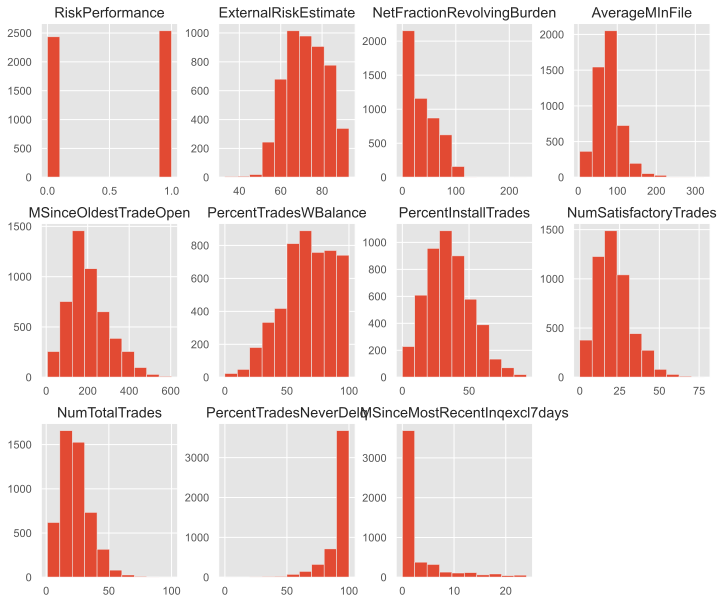

In [11]:
df.hist(layout=(3,4), figsize=(12, 10))
plt.show()

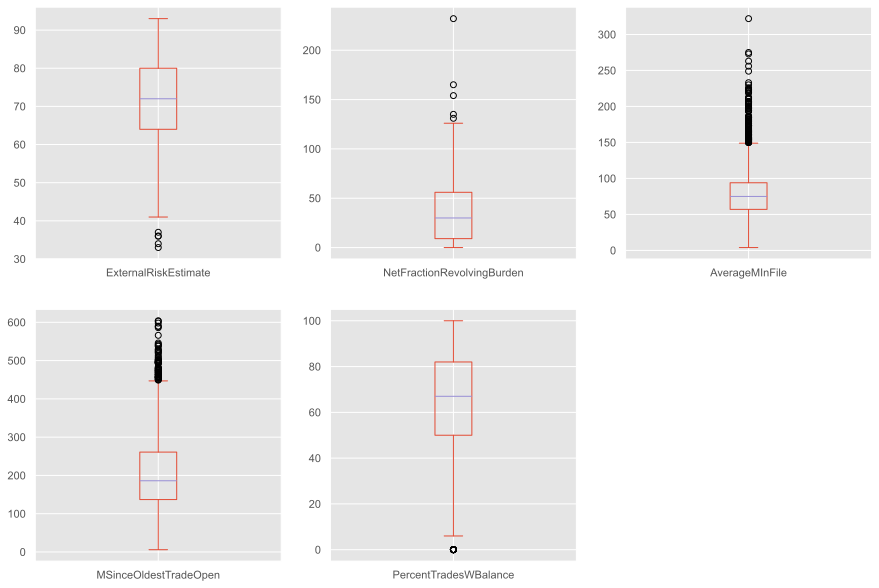

In [12]:
ax = df.loc[:, ['ExternalRiskEstimate', 'NetFractionRevolvingBurden',
       'AverageMInFile', 'MSinceOldestTradeOpen', 'PercentTradesWBalance']].plot(
    kind='box', subplots=True, layout=(2,3),figsize=(15, 10), sharex=False, sharey=False)  

#plt.savefig("Boxplots_EDA_1.jpg", bbox_inches='tight')

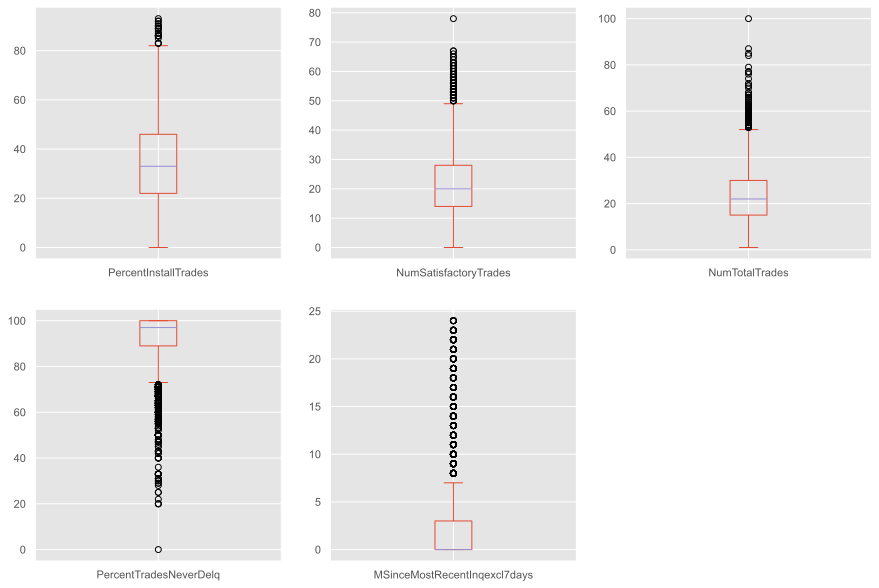

In [13]:
ax = df.loc[:, ['PercentInstallTrades', 'NumSatisfactoryTrades', 'NumTotalTrades',
       'PercentTradesNeverDelq', 'MSinceMostRecentInqexcl7days']].plot(
    kind='box', subplots=True, layout=(2,3), figsize=(15, 10), sharex=False, sharey=False) 
#plt.savefig("Boxplots_EDA_2.jpg", bbox_inches='tight')

Thanks to the boxplots, we realize that almost every variable has multiple outliers.
- 'ExternalRiskEstimate', 'PercentTradesWBalance' and 'PercentTradesNeverDelq' have only outliers with significant low values.
- While 'NetFractionRevolvingBurden', 'AverageMInFile', 'MSinceOldestTradeOpen', 'PercentInstallTrades', 'NumSatisfactoryTrades', 'NumTotalTrades' and 'MSinceMostRecentInqexcl7days'have only outliers with significant high values.

However, even though the graphs identify significantly large or small values, we cannot say with these boxplots alone that they are outlier values, we will only say that they are possible outlier values.

It will not be until the training of the models that we will be able to affirm such a theory.

Consequently, in the first instance we do not make any drop in these values.

#### STEP 4: ENCODE CATEGORICAL VARIABLES

Once we have identified the variables of the data set, and we know what their behavior is in general terms, we have to convert those variables that are categorical into factors.

In our case, only the output variable is categorical, that is, 'RiskPerformance'.

In [14]:
#First we change to int64 so then the values are 1 instead of 1.0
df.RiskPerformance = df.RiskPerformance.astype('int64')
df.RiskPerformance = df.RiskPerformance.astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4972 entries, 0 to 7291
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   RiskPerformance               4972 non-null   category
 1   ExternalRiskEstimate          4972 non-null   int64   
 2   NetFractionRevolvingBurden    4972 non-null   int64   
 3   AverageMInFile                4972 non-null   int64   
 4   MSinceOldestTradeOpen         4972 non-null   float64 
 5   PercentTradesWBalance         4972 non-null   float64 
 6   PercentInstallTrades          4972 non-null   int64   
 7   NumSatisfactoryTrades         4972 non-null   float64 
 8   NumTotalTrades                4972 non-null   float64 
 9   PercentTradesNeverDelq        4972 non-null   int64   
 10  MSinceMostRecentInqexcl7days  4972 non-null   int64   
dtypes: category(1), float64(4), int64(6)
memory usage: 432.3 KB


#### STEP 5: EXPLORATORY ANALYSIS  


In this section, we are going to study the correlation plot between the numeric input variables. To do this, we proceed to represent in a plot all the numerical variables with different color depending on their relationship with the categorical output variable 'RiskPerformance.

RiskPerformance:
0 - Blue
1 - Red


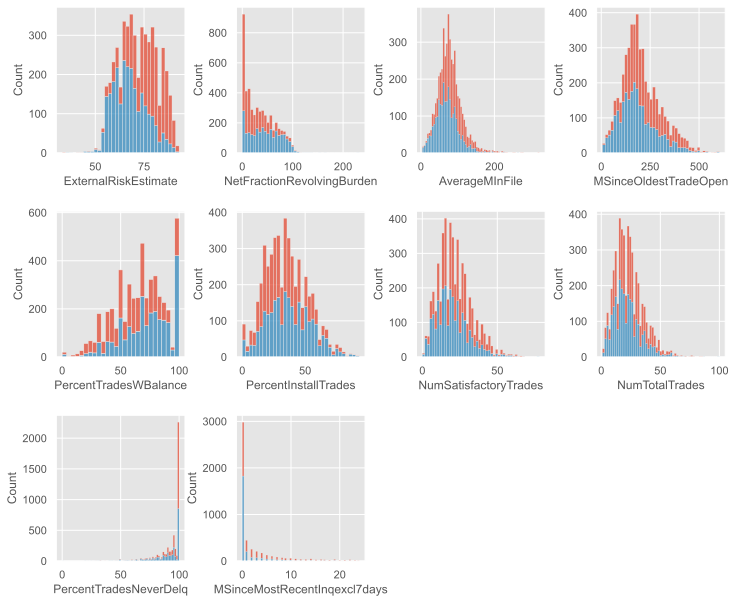

In [15]:
fig = plt.figure(figsize=(12,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
cols = ['ExternalRiskEstimate', 'NetFractionRevolvingBurden',
       'AverageMInFile', 'MSinceOldestTradeOpen', 'PercentTradesWBalance',
       'PercentInstallTrades', 'NumSatisfactoryTrades', 'NumTotalTrades',
       'PercentTradesNeverDelq', 'MSinceMostRecentInqexcl7days']
print('RiskPerformance:')
print('0 - Blue')
print('1 - Red')
for i in range(len(cols)):
    ax = fig.add_subplot(3, 4, i+1)
    sns.histplot(x = cols[i], hue = 'RiskPerformance', data = df, multiple='stack', ax=ax, legend=False)
plt.show()

In [16]:
#Pairplot
#sns.pairplot(df, hue='RiskPerformance')
#plt.show()

On the other hand, we also consider it important to obtain correlations between all the variables in the data set. The reason for this is that, if two variables have a correlation close to 1, it implies that both provide the same information and, consequently, it would be optimal to get rid of one of them.

Thus, we proceed to obtain a graph with the correlations.

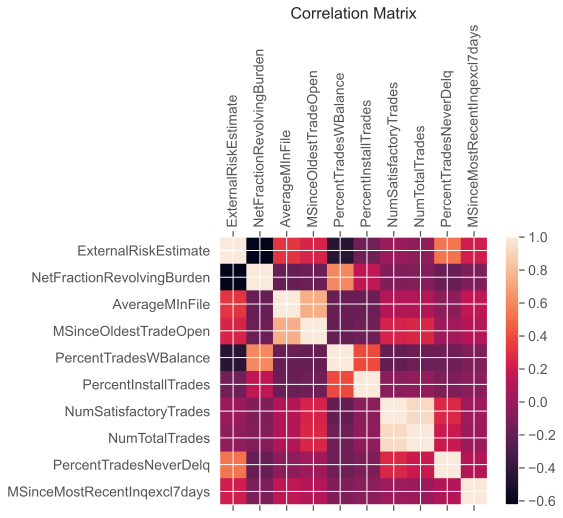

In [17]:
#Correlation plot of numeric variables
f = plt.figure()
plt.matshow(df.select_dtypes(include=['int64','float64']).corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(include=['int64','float64']).shape[1]), df.select_dtypes(include=['int64','float64']).columns, fontsize=14, rotation=90)
plt.yticks(range(df.select_dtypes(include=['int64','float64']).shape[1]), df.select_dtypes(include=['int64','float64']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
#plt.savefig("CorrelationMatrix.jpg", bbox_inches='tight')
plt.show()


From the graph above we can conclude the correlation between each pair of variables. For example, in this terms:

+ We observe how 'AverageMInFile' vs 'NetFractionRevolvingBurden' or 'NumSatisfacotryTrades' vs. 'ExternalRiskEstimate' have very low correlation (under 0), implying that they do not have a linear relationship , and it would be necessary to add all variables to the model as explanatory variables, since they provide different non-repetitive information.

+ On the other hand, we observe how ' NumTotalTrades' vs. 'NumSatisfacotryTrades' have a correlation around 0.9, which would imply that they have a high correlation, meaning that they would not provide additional information to the model, being able to dispense with one of them as an explanatory variable. Specifically, and in this case, in order to obtain exact the correlation between both variables, we proceed to calculate it explicitly and numerically.

In [18]:
np.corrcoef(df['NumTotalTrades'],df['NumSatisfactoryTrades'])

array([[1.        , 0.92770657],
       [0.92770657, 1.        ]])

Indeed, we observe that both variables have a correlation of 0.93, implying that they provide practically the same information and one of them could be omitted. 

However, since we want to keep the information on how many satisfactory operations we proceed to calculate the percentage of satisfactory operations over total operations, adding the result as a **new explanatory variable `PerSatTrades`**. 

In this way, we will keep the information related to successful transactions but avoid having a variable practically the same as `NumTotalTrades`.

In [19]:
df['PerSatTrades'] = df['NumSatisfactoryTrades']/df['NumTotalTrades']
df.head(n=5)

RiskPerformance  ExternalRiskEstimate  NetFractionRevolvingBurden  \
0               1                    55                          33   
1               1                    61                           0   
2               1                    67                          53   
3               1                    66                          72   
4               1                    81                          51   

   AverageMInFile  MSinceOldestTradeOpen  PercentTradesWBalance  \
0              84                  144.0                   69.0   
1              41                   58.0                    0.0   
2              24                   66.0                   86.0   
3              73                  169.0                   91.0   
4             132                  333.0                   80.0   

   PercentInstallTrades  NumSatisfactoryTrades  NumTotalTrades  \
0                    43                   20.0            23.0   
1                    67                    2.0             7.0   
2                    44                    9.0             9.0   
3                    57                   28.0            30.0   
4                    25                   12.0            12.0   

   PercentTradesNeverDelq  MSinceMostRecentInqexcl7days  PerSatTrades  
0                      83                             0      0.869565  
1                     100                             0      0.285714  
2                     100                             0      1.000000  
3                      93                             0      0.933333  
4                     100                             0      1.000000

In [20]:
df = df.drop(columns=['NumSatisfactoryTrades'])
df.head()

RiskPerformance  ExternalRiskEstimate  NetFractionRevolvingBurden  \
0               1                    55                          33   
1               1                    61                           0   
2               1                    67                          53   
3               1                    66                          72   
4               1                    81                          51   

   AverageMInFile  MSinceOldestTradeOpen  PercentTradesWBalance  \
0              84                  144.0                   69.0   
1              41                   58.0                    0.0   
2              24                   66.0                   86.0   
3              73                  169.0                   91.0   
4             132                  333.0                   80.0   

   PercentInstallTrades  NumTotalTrades  PercentTradesNeverDelq  \
0                    43            23.0                      83   
1                    67             7.0                     100   
2                    44             9.0                     100   
3                    57            30.0                      93   
4                    25            12.0                     100   

   MSinceMostRecentInqexcl7days  PerSatTrades  
0                             0      0.869565  
1                             0      0.285714  
2                             0      1.000000  
3                             0      0.933333  
4                             0      1.000000

#### STEP 6: CHECK OUT FOR CLASS IMBALANCES

In the analysis prior to model training, it is also very important to identify if there is any type of imbalance in the categorical variables, because some models do not behave correctly if this imbalance exists.

In our case, we can only parse it into the output variable.

In [21]:
df['RiskPerformance'].value_counts()

RiskPerformance
1    2538
0    2434
Name: count, dtype: int64

When analyzing the imbalance between classes of the output variable, we observed a difference of around 100 between both classes. Considering that we are working with a large data set, it could be considered a small difference, without having a significant consequence.

Consequently, we do not have to apply any balancing techniques.

#### STEP 7: SPLIT THE DATA INTO TRAINING AND TEST SETS

Finally, to prepare for the training of the models, we divide the data set into a train set (to train the model and achieve the optimal values ​​of the parameters and hyperparameters), and a test set to evaluate the predictive capacity of the model in question.

Specifically, we are going to use a random set of 20% of the total observations as a test set.

In [22]:
# Define input and output matrices
INPUTS = ['ExternalRiskEstimate', 'NetFractionRevolvingBurden',
       'AverageMInFile', 
          'MSinceOldestTradeOpen', 'PercentTradesWBalance','PercentInstallTrades', 'PerSatTrades', 'NumTotalTrades',
       'PercentTradesNeverDelq', 'MSinceMostRecentInqexcl7days'] 
OUTPUT = 'RiskPerformance' # variable de salida
X = df[INPUTS] 
y = df[OUTPUT]

# Split.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,   
                                                    random_state=0, 
                                                    stratify = y) 

In [23]:
X_train.head()

ExternalRiskEstimate  NetFractionRevolvingBurden  AverageMInFile  \
5112                    55                          65              24   
4163                    83                          27              98   
3974                    63                          83             111   
6268                    74                          42             140   
4690                    75                          61              79   

      MSinceOldestTradeOpen  PercentTradesWBalance  PercentInstallTrades  \
5112                   58.0                   89.0                    53   
4163                  204.0                   25.0                    21   
3974                  349.0                   91.0                     6   
6268                  297.0                   69.0                    21   
4690                  279.0                   60.0                    19   

      PerSatTrades  NumTotalTrades  PercentTradesNeverDelq  \
5112      0.947368            19.0                      95   
4163      1.000000            14.0                     100   
3974      0.971429            35.0                      97   
6268      0.857143            28.0                      89   
4690      1.000000            16.0                     100   

      MSinceMostRecentInqexcl7days  
5112                             0  
4163                             6  
3974                            19  
6268                             0  
4690                            22

In [24]:
y_train

5112    1
4163    0
3974    1
6268    1
4690    0
       ..
4934    0
3859    1
3424    1
7244    0
3498    1
Name: RiskPerformance, Length: 3977, dtype: category
Categories (2, int64): [0, 1]

In [25]:
## Create dataset to store model predictions
dfTR_eval = X_train.copy() # Crea 1 copia para toquetear esta y mantener train y test limpios.
dfTR_eval['Y'] = y_train # We will call Y as output variable for simplicity
dfTS_eval = X_test.copy()
dfTS_eval['Y'] = y_test # We will call Y as output variable for simplicity

Once we have the data set already analyzed and preprocessed, we can move on to the **model training part**.

Specifically, as the variable to be predicted is dichotomous categorical, the models that we are going to train and compare are the following:
- Logistic regression
- k nearest neighbors
- decision tree
- SVM
- Multi-layer Perceptron

With all these models we will carry out the adjustment and training of the model (if there are hyperparameters we will carry out a Cross-Validation for tuning), and we will analyze the results of each model.

For this analysis we will obtain, on the one hand, the average accuracy obtained in the CV, as well as the confusion matrices and error measures both on the train (it will inform us about the goodness of the fit), and on the test (predictive capacity).

### **2. Logistic Regression**

We start with the logistic regression model. Logistic Regression is a classification technique used in machine learning. It uses a logistic function to model the dependent variable. The dependent variable is dichotomous in nature, i.e. there could only be two possible classes. As a result, this technique is used while dealing with binary data. (https://towardsdatascience.com/the-perfect-recipe-for-classification-using-logistic-regression-f8648e267592)

First of all, I start by training the model with all the variables that we have left in the data set as inputs.

**2.1. All variables as lineal inputs**

In [26]:
# Training of the model:
INPUTS_LR = INPUTS
LogReg_fit = Pipeline(steps=[('scaler',StandardScaler()),
                        ('LogReg',LogisticRegression(penalty=None))]) 
LogReg_fit.fit(X_train[INPUTS_LR], y_train);

# Obtain Cross-Validation score
cv_log_reg1 = cross_val_score(LogReg_fit, X_train[INPUTS_LR], y_train, cv=5, scoring='accuracy')
print("CV accuracy is", cv_log_reg1.mean())
#print(cv_log_reg1)


CV accuracy is 0.7304522613065327


In [27]:
CT.summaryLogReg(LogReg_fit, X_train[INPUTS_LR], y_train)
#plt.save("SummaryLogReg.jpg", bbox_inches='tight')

Deviance Residuals:
        Min        1Q    Median        3Q       Max
0 -0.992429 -0.324903  0.059866  0.330011  0.975149

Coefficients:
                              Estimate
Intercept                     0.058689
ExternalRiskEstimate         -0.679870
NetFractionRevolvingBurden    0.369848
AverageMInFile               -0.249237
MSinceOldestTradeOpen         0.040825
PercentTradesWBalance        -0.034587
PercentInstallTrades          0.130478
PerSatTrades                 -0.086786
NumTotalTrades               -0.270512
PercentTradesNeverDelq       -0.140841
MSinceMostRecentInqexcl7days -0.299116
                              Estimate  Std. Err    t-value      Pr(>|t|)  \
Intercept                     0.058689  0.036925   1.589410  1.119678e-01   
ExternalRiskEstimate         -0.679870  0.066239 -10.263914  0.000000e+00   
NetFractionRevolvingBurden    0.369848  0.056601   6.534283  6.391487e-11   
AverageMInFile               -0.249237  0.061955  -4.022868  5.749365e-05   
MSinceOl

In [28]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_LR_pred'] = LogReg_fit.predict(X_train[INPUTS_LR])
dfTR_eval['Y_LR_prob_neg'] = LogReg_fit.predict_proba(X_train[INPUTS_LR])[:,0]
dfTR_eval['Y_LR_prob_pos'] = LogReg_fit.predict_proba(X_train[INPUTS_LR])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_LR_pred'] = LogReg_fit.predict(X_test)
dfTS_eval['Y_LR_prob_neg'] = LogReg_fit.predict_proba(X_test[INPUTS_LR])[:,0]
dfTS_eval['Y_LR_prob_pos'] = LogReg_fit.predict_proba(X_test[INPUTS_LR])[:,1]

#visualize evaluated data
dfTR_eval.head()

ExternalRiskEstimate  NetFractionRevolvingBurden  AverageMInFile  \
5112                    55                          65              24   
4163                    83                          27              98   
3974                    63                          83             111   
6268                    74                          42             140   
4690                    75                          61              79   

      MSinceOldestTradeOpen  PercentTradesWBalance  PercentInstallTrades  \
5112                   58.0                   89.0                    53   
4163                  204.0                   25.0                    21   
3974                  349.0                   91.0                     6   
6268                  297.0                   69.0                    21   
4690                  279.0                   60.0                    19   

      PerSatTrades  NumTotalTrades  PercentTradesNeverDelq  \
5112      0.947368            19.0                      95   
4163      1.000000            14.0                     100   
3974      0.971429            35.0                      97   
6268      0.857143            28.0                      89   
4690      1.000000            16.0                     100   

      MSinceMostRecentInqexcl7days  Y  Y_LR_pred  Y_LR_prob_neg  Y_LR_prob_pos  
5112                             0  1          1       0.091799       0.908201  
4163                             6  0          0       0.753859       0.246141  
3974                            19  1          0       0.629885       0.370115  
6268                             0  1          0       0.612426       0.387574  
4690                            22  0          0       0.743020       0.256980

In [29]:
#Confusion matrix for Log Reg Model
print("----- TRAINING CONFUSION MATRIX -----")
CT.confusion_matrix(dfTR_eval['Y'], dfTR_eval['Y_LR_pred'],labels=[0,1])

----- TRAINING CONFUSION MATRIX -----
Confusion Matrix and Statistics
	   Prediction
 Reference    0    1
         0 1402  545
         1  525 1505

Accuracy: 0.73
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.46
Mcnemar's Test P-Value: 0.56
Sensitivity: 0.74
Specificity: 0.72
Precision: 0.73
Recall: 0.72
Prevalence: 0.51
Detection Rate: 0.38
Detection prevalence: 0.52
Balanced accuracy: 0.73
F1 Score: 0.72
Positive label: 0


In [30]:
print("----- TEST CONFUSION MATRIX-----")
CT.confusion_matrix(dfTS_eval['Y'], dfTS_eval['Y_LR_pred'],labels=[0,1])

----- TEST CONFUSION MATRIX-----
Confusion Matrix and Statistics
	   Prediction
 Reference   0   1
         0 352 135
         1 127 381

Accuracy: 0.74
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.47
Mcnemar's Test P-Value: 0.67
Sensitivity: 0.75
Specificity: 0.72
Precision: 0.73
Recall: 0.72
Prevalence: 0.51
Detection Rate: 0.38
Detection prevalence: 0.52
Balanced accuracy: 0.74
F1 Score: 0.73
Positive label: 0


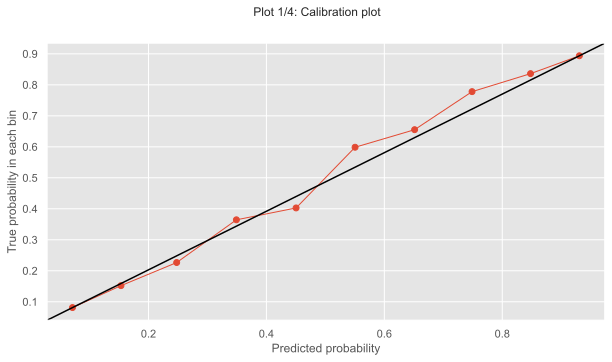

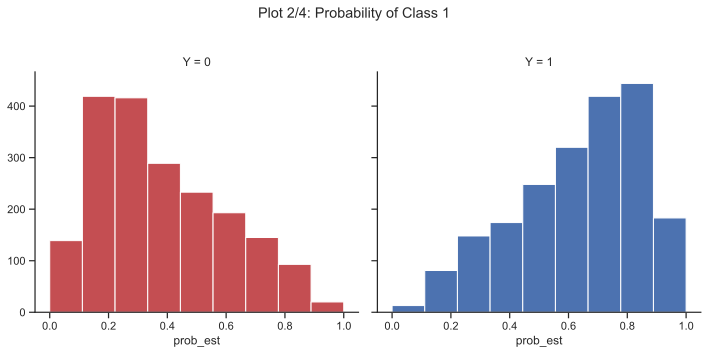

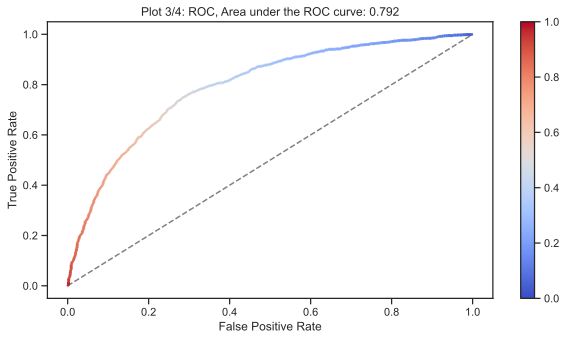

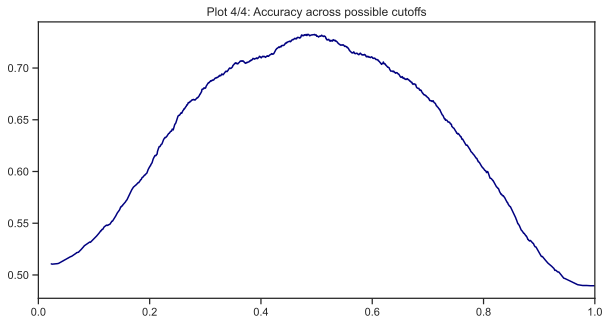

In [31]:
#CT.plotClassPerformance(dfTR_eval['Y'], LogReg_fit.predict_proba(X_train[INPUTS_LR]), selClass=1)

CT.plotClassPerformance(dfTR_eval['Y'], LogReg_fit.predict_proba(X_train[INPUTS_LR]), selClass=1)
#plt.savefig("GraphsLogReg.jpg", bbox_inches='tight')

##### Conclusions (2.1):

- We have used all the variables and we have only considered linear relationships
- The average accuracy in cross-validation is 0.7305
- The accuracy in the train (model adjustment) has been 0.73
- The accuracy in the test (predictive ability) has been 0.74
- Since they are equal, we have not fallen into overfitting
- The accuracy if we considered all the obs. 0 or 1 would be 0.5 ('No Information Rate'), as our accuracy is much higher, it makes sense to launch the model
- **Important:** not all variables appear as significant:
    - MSinceOldestTradeOpen and PercentTradesWBalance are not statistically significant.
    - ExternalRiskEstimate, NetFractionRevolvingBurden, AverageMInFile and MSinceMostRecentInqexcl7days are the most significant variables.

**Proposal:** Given that 3 variables did not seem significant in our model, we can 1) repeat the adjustment but excluding these variables and check if our predictive capacity improves, and 2) launch a model that considers non-linear relationships on non-linear variables. significant.


**2.2. Only significant variables as lineal inputs**

We repeat the same procedure but only considering as inputs the variables that in 2.1. appeared as significant in the model.

In [32]:
# Define input and output matrices
INPUTS = ['ExternalRiskEstimate', 'NetFractionRevolvingBurden',
       'AverageMInFile','PercentInstallTrades', 'PerSatTrades', 'NumTotalTrades',
       'PercentTradesNeverDelq', 'MSinceMostRecentInqexcl7days'] 
OUTPUT = 'RiskPerformance' 
X = df[INPUTS] 
y = df[OUTPUT]

# Split.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,   
                                                    random_state=0, 
                                                    stratify = y) 

## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['Y'] = y_train # We will call Y as output variable for simplicity
dfTS_eval = X_test.copy()
dfTS_eval['Y'] = y_test # We will call Y as output variable for simplicity

# Training of the model:
INPUTS_LR = INPUTS
LogReg_fit = Pipeline(steps=[('scaler',StandardScaler()),
                        ('LogReg',LogisticRegression(penalty=None))]) 
LogReg_fit.fit(X_train[INPUTS_LR], y_train);
print("Logistic Regression Trained")

# Obtain Cross-Validation score
print("CV accuracy is", cross_val_score(LogReg_fit, X_train[INPUTS_LR], y_train, cv=5, scoring='accuracy').mean())
cv_log_reg2 = cross_val_score(LogReg_fit, X_train[INPUTS_LR], y_train, cv=5, scoring='accuracy')
#print(cv_log_reg2)


Logistic Regression Trained
CV accuracy is 0.7291943996713125


In [33]:
# Summary del modelo
print(CT.summaryLogReg(LogReg_fit, X_train[INPUTS_LR], y_train))


Deviance Residuals:
        Min        1Q    Median        3Q       Max
0 -0.992416 -0.324857  0.059922  0.329303  0.971383

Coefficients:
                              Estimate
Intercept                     0.058345
ExternalRiskEstimate         -0.674342
NetFractionRevolvingBurden    0.352550
AverageMInFile               -0.219604
PercentInstallTrades          0.118405
PerSatTrades                 -0.087628
NumTotalTrades               -0.258978
PercentTradesNeverDelq       -0.142215
MSinceMostRecentInqexcl7days -0.299281
                              Estimate  Std. Err    t-value      Pr(>|t|)  \
Intercept                     0.058345  0.036912   1.580640  1.139604e-01   
ExternalRiskEstimate         -0.674342  0.065716 -10.261459  0.000000e+00   
NetFractionRevolvingBurden    0.352550  0.050835   6.935247  4.055201e-12   
AverageMInFile               -0.219604  0.043768  -5.017478  5.235409e-07   
PercentInstallTrades          0.118405  0.038128   3.105493  1.899620e-03   
PerSatTra

In [34]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_LR_pred'] = LogReg_fit.predict(X_train[INPUTS_LR])
dfTR_eval['Y_LR_prob_neg'] = LogReg_fit.predict_proba(X_train[INPUTS_LR])[:,0]
dfTR_eval['Y_LR_prob_pos'] = LogReg_fit.predict_proba(X_train[INPUTS_LR])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_LR_pred'] = LogReg_fit.predict(X_test)
dfTS_eval['Y_LR_prob_neg'] = LogReg_fit.predict_proba(X_test[INPUTS_LR])[:,0]
dfTS_eval['Y_LR_prob_pos'] = LogReg_fit.predict_proba(X_test[INPUTS_LR])[:,1]

#visualize evaluated data
dfTR_eval.head()

ExternalRiskEstimate  NetFractionRevolvingBurden  AverageMInFile  \
5112                    55                          65              24   
4163                    83                          27              98   
3974                    63                          83             111   
6268                    74                          42             140   
4690                    75                          61              79   

      PercentInstallTrades  PerSatTrades  NumTotalTrades  \
5112                    53      0.947368            19.0   
4163                    21      1.000000            14.0   
3974                     6      0.971429            35.0   
6268                    21      0.857143            28.0   
4690                    19      1.000000            16.0   

      PercentTradesNeverDelq  MSinceMostRecentInqexcl7days  Y  Y_LR_pred  \
5112                      95                             0  1          1   
4163                     100                             6  0          0   
3974                      97                            19  1          0   
6268                      89                             0  1          0   
4690                     100                            22  0          0   

      Y_LR_prob_neg  Y_LR_prob_pos  
5112       0.091563       0.908437  
4163       0.760563       0.239437  
3974       0.628257       0.371743  
6268       0.604098       0.395902  
4690       0.752712       0.247288

In [35]:
#Confusion matrix for Log Reg Model
print("----- TRAINING CONFUSION MATRIX -----")
CT.confusion_matrix(dfTR_eval['Y'], dfTR_eval['Y_LR_pred'],labels=[0,1])

----- TRAINING CONFUSION MATRIX -----
Confusion Matrix and Statistics
	   Prediction
 Reference    0    1
         0 1398  549
         1  525 1505

Accuracy: 0.73
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.46
Mcnemar's Test P-Value: 0.48
Sensitivity: 0.74
Specificity: 0.72
Precision: 0.73
Recall: 0.72
Prevalence: 0.51
Detection Rate: 0.38
Detection prevalence: 0.52
Balanced accuracy: 0.73
F1 Score: 0.72
Positive label: 0


In [36]:
print("----- TEST CONFUSION MATRIX-----")
CT.confusion_matrix(dfTS_eval['Y'], dfTS_eval['Y_LR_pred'],labels=[0,1])

----- TEST CONFUSION MATRIX-----
Confusion Matrix and Statistics
	   Prediction
 Reference   0   1
         0 350 137
         1 124 384

Accuracy: 0.74
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.47
Mcnemar's Test P-Value: 0.46
Sensitivity: 0.76
Specificity: 0.72
Precision: 0.74
Recall: 0.72
Prevalence: 0.51
Detection Rate: 0.39
Detection prevalence: 0.52
Balanced accuracy: 0.74
F1 Score: 0.73
Positive label: 0


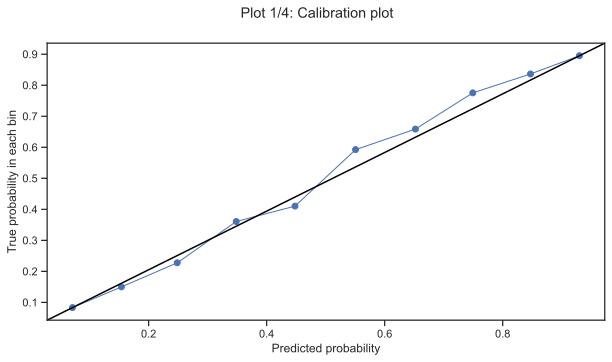

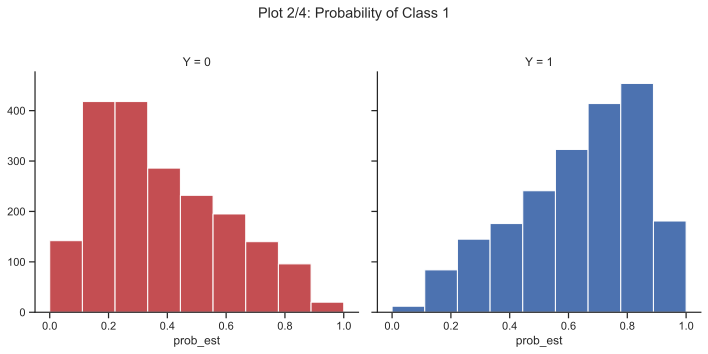

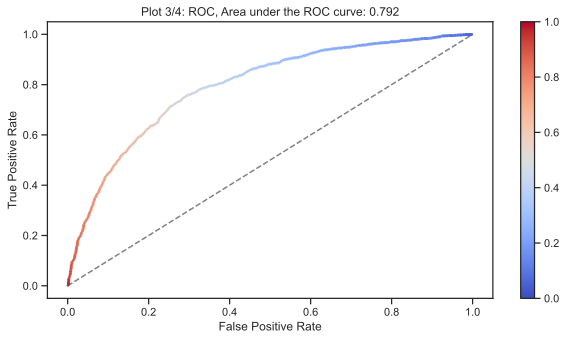

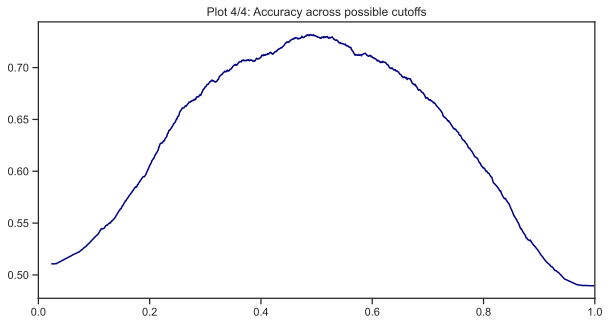

In [37]:
CT.plotClassPerformance(dfTR_eval['Y'], LogReg_fit.predict_proba(X_train[INPUTS_LR]), selClass=1)

##### Conclusions (2.2):

- We obtain the same accuracy values ​​both in the goodness of fit and in terms of predictive capacity.

- Consequently, no improvement is observed from the elimination of 2 of the variables.

**2.3. Only significant variables as lineal inputs and non significant ones as squared inputs**

In [38]:
# Define input and output matrices
INPUTS = ['ExternalRiskEstimate', 'NetFractionRevolvingBurden',
       'AverageMInFile', 
          'MSinceOldestTradeOpen', 'PercentTradesWBalance','PercentInstallTrades', 'PerSatTrades', 'NumTotalTrades',
       'PercentTradesNeverDelq', 'MSinceMostRecentInqexcl7days'] 
OUTPUT = 'RiskPerformance' # variable de salida
X = df[INPUTS] 
y = df[OUTPUT]

# Split.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,   
                                                    random_state=0, 
                                                    stratify = y) 
## Create dataset to store model predictions
dfTR_eval = X_train.copy() # Crea 1 copia para toquetear esta y mantener train y test limpios.
dfTR_eval['Y'] = y_train # We will call Y as output variable for simplicity
dfTS_eval = X_test.copy()
dfTS_eval['Y'] = y_test # We will call Y as output variable for simplicity


In [39]:
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_LR2_NUM = ['ExternalRiskEstimate', 'NetFractionRevolvingBurden',
       'AverageMInFile','PercentInstallTrades', 'PerSatTrades', 'NumTotalTrades',
       'PercentTradesNeverDelq', 'MSinceMostRecentInqexcl7days'] 

INPUTS_LR2_SQ = ["MSinceOldestTradeOpen", "PercentTradesWBalance"]  
INPUTS_LR2_CAT = []   
INPUTS_LR2 = INPUTS_LR2_NUM + INPUTS_LR2_SQ + INPUTS_LR2_CAT

# Prepare the numeric variables by scaling
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Prepare the numeric variables by scaling
square_transformer = Pipeline(steps=[('scaler', StandardScaler()),
                                      ('Poly',PolynomialFeatures())]) 

# Prepare the categorical variables by encoding the categories
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]) 

# Create a preprocessor to perform the steps defined above   
preprocessor = ColumnTransformer(transformers=[         
        ('num', numeric_transformer, INPUTS_LR2_NUM),   
        ('sq', square_transformer, INPUTS_LR2_SQ),
        ('cat', categorical_transformer, INPUTS_LR2_CAT)
        ])

pipe = Pipeline(steps=[('Prep',preprocessor), # Preprocess the variables when training the model 
                       ('LogReg',LogisticRegression(fit_intercept=False, penalty=None))]) # Avoid using intercept when using polynomial features

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
param = {}
LogReg_fit_sq = GridSearchCV(estimator=pipe, # Structure of the model to use
                            param_grid=param, # Defined grid to search in
                            n_jobs=-1, # Number of cores to use (parallelize)
                            scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                            cv=nFolds) # Number of Folds 
#Train model
LogReg_fit_sq.fit(X_train[INPUTS_LR2], y_train)


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('Prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['ExternalRiskEstimate',
                                                                          'NetFractionRevolvingBurden',
                                                                          'AverageMInFile',
                                                                          'PercentInstallTrades',
                                                                          'PerSatTrades',
                                                                          'NumTotalTrades',
                                                                          'PercentTradesNeverDelq',
                                                                          'MSinceMostRecentInqexcl7days']),
                                                                        ('sq',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler()),
                                                                                         ('Poly',
                                                                                          PolynomialFeatures())]),
                                                                         ['MSinceOldestTradeOpen',
                                                                          'PercentTradesWBalance']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         [])])),
                                       ('LogReg',
                                        LogisticRegression(fit_intercept=False,
                                                           penalty=None))]),
             n_jobs=-1, param_grid={}, scoring='accuracy')

In [40]:
# Obtain Cross-Validation score
cv_log_reg3 = cross_val_score(LogReg_fit_sq, X_train[INPUTS_LR2], y_train, cv=5, scoring='accuracy')
print("CV accuracy is", cv_log_reg3.mean())
print(cv_log_reg3)

CV accuracy is 0.7261764798836953
[0.73743719 0.71105528 0.72075472 0.72578616 0.73584906]


In [41]:
CT.summaryLogReg(LogReg_fit_sq.best_estimator_, X_train[INPUTS_LR2], y_train)


Deviance Residuals:
        Min        1Q    Median        3Q       Max
0 -0.993357 -0.322765  0.052229  0.332633  0.970824

Coefficients:
                                             Estimate
ExternalRiskEstimate                        -0.657279
NetFractionRevolvingBurden                   0.375818
AverageMInFile                              -0.212167
PercentInstallTrades                         0.134767
PerSatTrades                                -0.087205
NumTotalTrades                              -0.231313
PercentTradesNeverDelq                      -0.164878
MSinceMostRecentInqexcl7days                -0.298967
1                                           -0.060449
MSinceOldestTradeOpen                       -0.070188
PercentTradesWBalance                       -0.022493
MSinceOldestTradeOpen^2                      0.087891
MSinceOldestTradeOpen PercentTradesWBalance -0.061758
PercentTradesWBalance^2                      0.032270
                                             Estima

In [42]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_LR_sq_pred'] = LogReg_fit_sq.predict(X_train[INPUTS_LR2])
dfTR_eval['Y_LR_sq_prob_neg'] = LogReg_fit_sq.predict_proba(X_train[INPUTS_LR2])[:,0]
dfTR_eval['Y_LR_sq_prob_pos'] = LogReg_fit_sq.predict_proba(X_train[INPUTS_LR2])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_LR_sq_pred'] = LogReg_fit_sq.predict(X_test[INPUTS_LR2])
dfTS_eval['Y_LR_sq_prob_neg'] = LogReg_fit_sq.predict_proba(X_test[INPUTS_LR2])[:,0]
dfTS_eval['Y_LR_sq_prob_pos'] = LogReg_fit_sq.predict_proba(X_test[INPUTS_LR2])[:,1]

#visualize evaluated data
dfTR_eval.head()

ExternalRiskEstimate  NetFractionRevolvingBurden  AverageMInFile  \
5112                    55                          65              24   
4163                    83                          27              98   
3974                    63                          83             111   
6268                    74                          42             140   
4690                    75                          61              79   

      MSinceOldestTradeOpen  PercentTradesWBalance  PercentInstallTrades  \
5112                   58.0                   89.0                    53   
4163                  204.0                   25.0                    21   
3974                  349.0                   91.0                     6   
6268                  297.0                   69.0                    21   
4690                  279.0                   60.0                    19   

      PerSatTrades  NumTotalTrades  PercentTradesNeverDelq  \
5112      0.947368            19.0                      95   
4163      1.000000            14.0                     100   
3974      0.971429            35.0                      97   
6268      0.857143            28.0                      89   
4690      1.000000            16.0                     100   

      MSinceMostRecentInqexcl7days  Y  Y_LR_sq_pred  Y_LR_sq_prob_neg  \
5112                             0  1             1          0.071192   
4163                             6  0             0          0.759531   
3974                            19  1             0          0.650062   
6268                             0  1             0          0.624958   
4690                            22  0             0          0.774148   

      Y_LR_sq_prob_pos  
5112          0.928808  
4163          0.240469  
3974          0.349938  
6268          0.375042  
4690          0.225852

In [43]:
#Confusion matrix for Log Reg Model
print("----- TRAINING CONFUSION MATRIX -----")
CT.confusion_matrix(dfTR_eval['Y'], dfTR_eval['Y_LR_sq_pred'], labels=[0,1])

----- TRAINING CONFUSION MATRIX -----
Confusion Matrix and Statistics
	   Prediction
 Reference    0    1
         0 1406  541
         1  538 1492

Accuracy: 0.73
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.46
Mcnemar's Test P-Value: 0.95
Sensitivity: 0.73
Specificity: 0.72
Precision: 0.72
Recall: 0.72
Prevalence: 0.51
Detection Rate: 0.38
Detection prevalence: 0.51
Balanced accuracy: 0.73
F1 Score: 0.72
Positive label: 0


In [44]:
print("----- TEST CONFUSION MATRIX-----")
CT.confusion_matrix(dfTS_eval['Y'], dfTS_eval['Y_LR_sq_pred'], labels=[0,1])

----- TEST CONFUSION MATRIX-----
Confusion Matrix and Statistics
	   Prediction
 Reference   0   1
         0 359 128
         1 130 378

Accuracy: 0.74
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.48
Mcnemar's Test P-Value: 0.95
Sensitivity: 0.74
Specificity: 0.74
Precision: 0.73
Recall: 0.74
Prevalence: 0.51
Detection Rate: 0.38
Detection prevalence: 0.51
Balanced accuracy: 0.74
F1 Score: 0.74
Positive label: 0


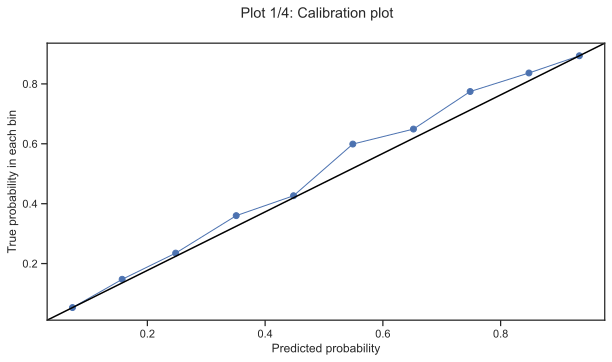

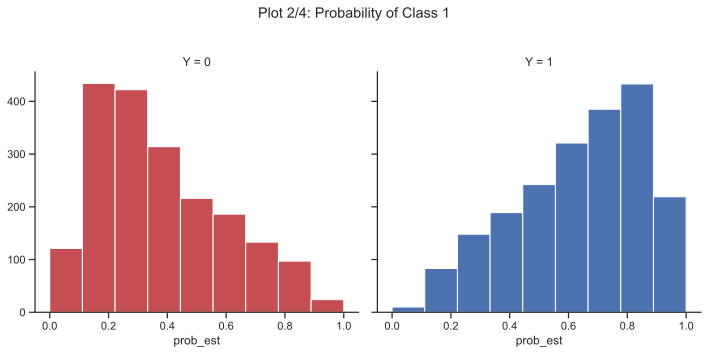

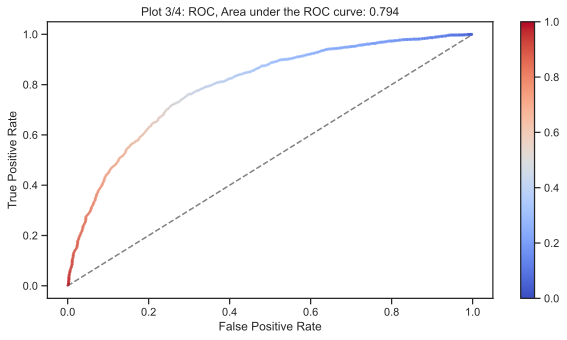

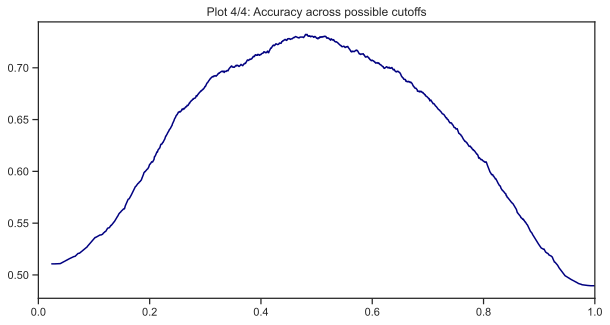

In [45]:
CT.plotClassPerformance(dfTR_eval['Y'], LogReg_fit_sq.predict_proba(X_train[INPUTS_LR2]), selClass=1)

##### Conclusions (2.3):

- We obtain the same accuracy values ​​both in the goodness of fit and in terms of predictive capacity.

- In fact, regarding the average accuracy of the cross-validation, we obtain an accuracy that is even a few tenths lower.

- Furthermore, when looking for which variables are significant in this model, we once again have those that were already significant in the previous models, and of the squared ones, we only find that MSinceOldestTradeOpen it does become significant.

- But, since the predictions have worsened, it does not make sense to carry out this new model.

### **3. kNN model**

In [46]:
# Define input and output matrices
INPUTS = ['ExternalRiskEstimate', 'NetFractionRevolvingBurden',
       'AverageMInFile', 
          'MSinceOldestTradeOpen', 'PercentTradesWBalance','PercentInstallTrades', 'PerSatTrades', 'NumTotalTrades',
       'PercentTradesNeverDelq', 'MSinceMostRecentInqexcl7days'] 
OUTPUT = 'RiskPerformance' # variable de salida
X = df[INPUTS] 
y = df[OUTPUT]

# Split.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,   
                                                    random_state=0, 
                                                    stratify = y) 
## Create dataset to store model predictions
dfTR_eval = X_train.copy() # Crea 1 copia para toquetear esta y mantener train y test limpios.
dfTR_eval['Y'] = y_train # We will call Y as output variable for simplicity
dfTS_eval = X_test.copy()
dfTS_eval['Y'] = y_test # We will call Y as output variable for simplicity
#---------- KNN MODEL ------------------
## Inputs of the model. Change accordingly to
INPUTS_KNN = INPUTS

## Configure model and hyparameter tuning
param = {'knn__n_neighbors': range(3,135,4)} #Number of neighbors  DECIMOS QUE QUEREMOS TUNEAR EL HIP. CON ESOS POSIBLES VALORES
# param = {'knn__n_neighbors': [150]} # Uncomment in case only one parameter is wanted

# Scale data previous to fit
pipe = Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsClassifier())]) 

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
knn_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                        param_grid=param, # Defined grid to search in
                        n_jobs=-1, # Number of cores to use (parallelize)
                        scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                        cv=nFolds) # Number of Folds 

# Search in grid and train model --------------------
knn_fit.fit(X_train[INPUTS_KNN], y_train)  #HAGO EL FIT SOBRE EL GRIDSEARCH DEL CV

print("kNN Trained")

kNN Trained


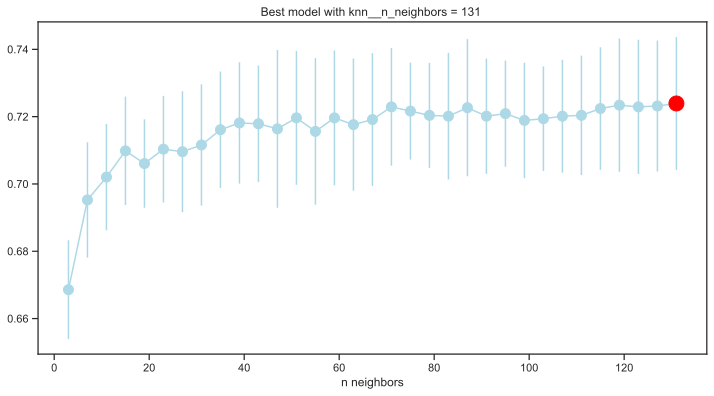

In [47]:
MT.plotModelGridError(knn_fit)

In [48]:
## Configure model and hyparameter tuning
param = {'knn__n_neighbors': range(130,200,4)} #Number of neighbors  DECIMOS QUE QUEREMOS TUNEAR EL HIP. CON ESOS POSIBLES VALORES
# param = {'knn__n_neighbors': [150]} # Uncomment in case only one parameter is wanted

# Scale data previous to fit
pipe = Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsClassifier())]) 

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
knn_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                        param_grid=param, # Defined grid to search in
                        n_jobs=-1, # Number of cores to use (parallelize)
                        scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                        cv=nFolds) # Number of Folds 

# Search in grid and train model --------------------
knn_fit.fit(X_train[INPUTS_KNN], y_train)  #HAGO EL FIT SOBRE EL GRIDSEARCH DEL CV

print("kNN Trained")

kNN Trained


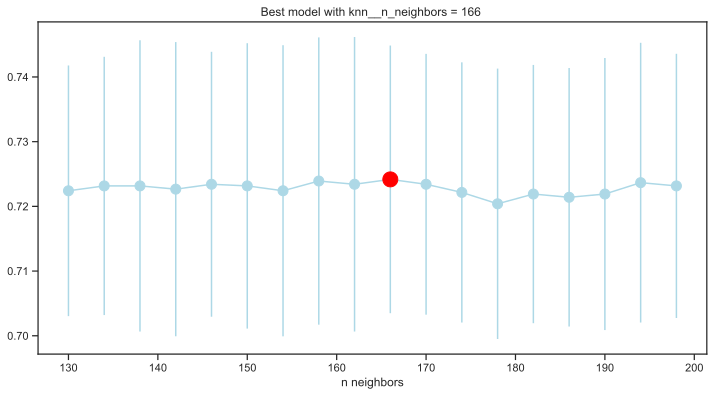

In [49]:
MT.plotModelGridError(knn_fit)

In [50]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_knn_pred'] = knn_fit.predict(X_train[INPUTS_KNN])
dfTR_eval['Y_knn_prob_neg'] = knn_fit.predict_proba(X_train[INPUTS_KNN])[:,0]
dfTR_eval['Y_knn_prob_pos'] = knn_fit.predict_proba(X_train[INPUTS_KNN])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_knn_pred'] = knn_fit.predict(X_test[INPUTS_KNN])
dfTS_eval['Y_knn_prob_neg'] = knn_fit.predict_proba(X_test[INPUTS_KNN])[:,0]
dfTS_eval['Y_knn_prob_pos'] = knn_fit.predict_proba(X_test[INPUTS_KNN])[:,1]

In [51]:
CT.confusion_matrix(dfTR_eval['Y'], dfTR_eval['Y_knn_pred'], labels=[0,1])

Confusion Matrix and Statistics
	   Prediction
 Reference    0    1
         0 1424  523
         1  570 1460

Accuracy: 0.73
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.45
Mcnemar's Test P-Value: 0.16
Sensitivity: 0.72
Specificity: 0.73
Precision: 0.71
Recall: 0.73
Prevalence: 0.51
Detection Rate: 0.37
Detection prevalence: 0.5
Balanced accuracy: 0.73
F1 Score: 0.72
Positive label: 0


In [52]:
CT.confusion_matrix(dfTS_eval['Y'], dfTS_eval['Y_knn_pred'], labels=[0,1])

Confusion Matrix and Statistics
	   Prediction
 Reference   0   1
         0 365 122
         1 136 372

Accuracy: 0.74
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.48
Mcnemar's Test P-Value: 0.42
Sensitivity: 0.73
Specificity: 0.75
Precision: 0.73
Recall: 0.75
Prevalence: 0.51
Detection Rate: 0.37
Detection prevalence: 0.5
Balanced accuracy: 0.74
F1 Score: 0.74
Positive label: 0


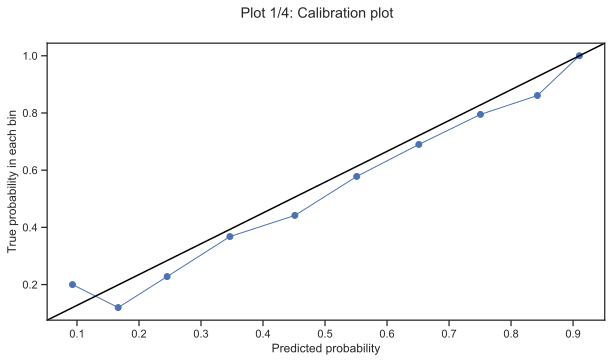

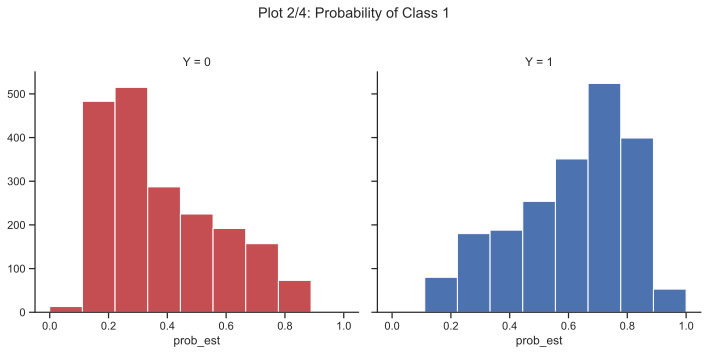

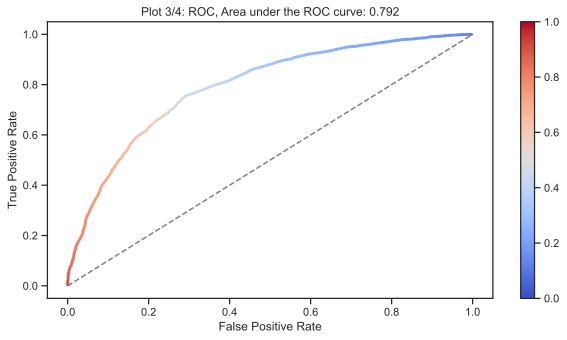

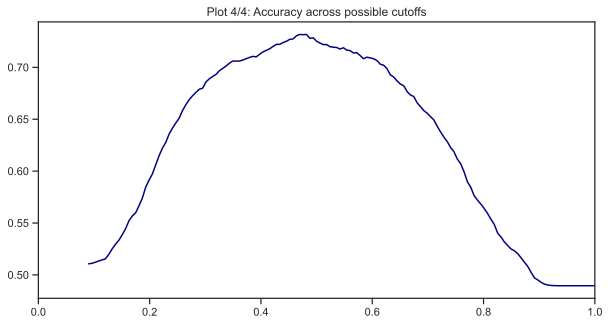

In [53]:
CT.plotClassPerformance(dfTR_eval['Y'], knn_fit.predict_proba(X_train[INPUTS_KNN]), selClass=1)

In [54]:
print(cross_val_score(knn_fit, X_train[INPUTS_KNN], y_train, cv=5, scoring='accuracy'))

[0.73241206 0.69723618 0.72704403 0.71949686 0.73584906]


#### Probando con variables más significativas obtenidas en el Modelo de Regresión Logística:
Se procede a volver a entrenar el modelo, esta vez utilizando como inputs aquellas variables que obtuvimos como más significativas tras realizar el modelo de Regresión Logística con variables no lineales. Dichas variables son:
- $ExternalRiskEstimate$
- $NetFractionRevolvingBurden$
- $AverageMInFile$
- $PercentInstallTrades$
- $PerSatTrades$
- $NumTotalTrades$
- $PercentTradesNeverDelq$
- $MSinceMostRecentInqexcl7days$
- $MSinceOldestTradeOpen^2$

In [55]:
#---------- KNN MODEL ------------------

## Inputs of the model. Change accordingly to
df['MSinceOldestTradeOpen_Squared']=df['MSinceOldestTradeOpen']**2
INPUTS_KNN = ['ExternalRiskEstimate', 'NetFractionRevolvingBurden',
       'AverageMInFile', 'PercentInstallTrades', 'PerSatTrades', 'NumTotalTrades',
       'PercentTradesNeverDelq', 'MSinceMostRecentInqexcl7days','MSinceOldestTradeOpen_Squared'] 
OUTPUT = 'RiskPerformance' # variable de salida
X = df[INPUTS_KNN] 
y = df[OUTPUT]

# Split.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,   
                                                    random_state=0, 
                                                    stratify = y) 

## Configure model and hyparameter tuning
param = {'knn__n_neighbors': range(3,135,4)} #Number of neighbors  DECIMOS QUE QUEREMOS TUNEAR EL HIP. CON ESOS POSIBLES VALORES
# param = {'knn__n_neighbors': [150]} # Uncomment in case only one parameter is wanted

# Scale data previous to fit
pipe = Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsClassifier())]) 

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
knn_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                        param_grid=param, # Defined grid to search in
                        n_jobs=-1, # Number of cores to use (parallelize)
                        scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                        cv=nFolds) # Number of Folds 

# Search in grid and train model --------------------
knn_fit.fit(X_train[INPUTS_KNN], y_train)  #HAGO EL FIT SOBRE EL GRIDSEARCH DEL CV

print("kNN Trained")

kNN Trained


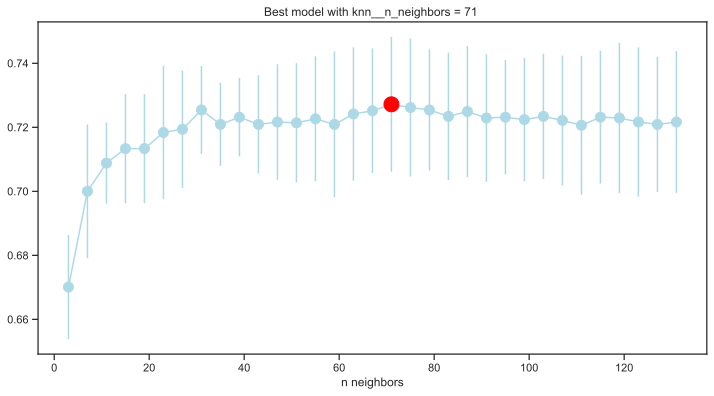

In [56]:
MT.plotModelGridError(knn_fit)

In [57]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_knn_pred'] = knn_fit.predict(X_train[INPUTS_KNN])
dfTR_eval['Y_knn_prob_neg'] = knn_fit.predict_proba(X_train[INPUTS_KNN])[:,0]
dfTR_eval['Y_knn_prob_pos'] = knn_fit.predict_proba(X_train[INPUTS_KNN])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_knn_pred'] = knn_fit.predict(X_test[INPUTS_KNN])
dfTS_eval['Y_knn_prob_neg'] = knn_fit.predict_proba(X_test[INPUTS_KNN])[:,0]
dfTS_eval['Y_knn_prob_pos'] = knn_fit.predict_proba(X_test[INPUTS_KNN])[:,1]

In [58]:
CT.confusion_matrix(dfTR_eval['Y'], dfTR_eval['Y_knn_pred'], labels=[0,1])

Confusion Matrix and Statistics
	   Prediction
 Reference    0    1
         0 1412  535
         1  532 1498

Accuracy: 0.73
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.46
Mcnemar's Test P-Value: 0.95
Sensitivity: 0.74
Specificity: 0.73
Precision: 0.73
Recall: 0.73
Prevalence: 0.51
Detection Rate: 0.38
Detection prevalence: 0.51
Balanced accuracy: 0.73
F1 Score: 0.73
Positive label: 0


In [59]:
CT.confusion_matrix(dfTS_eval['Y'], dfTS_eval['Y_knn_pred'], labels=[0,1])

Confusion Matrix and Statistics
	   Prediction
 Reference   0   1
         0 359 128
         1 133 375

Accuracy: 0.74
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.48
Mcnemar's Test P-Value: 0.8
Sensitivity: 0.74
Specificity: 0.74
Precision: 0.73
Recall: 0.74
Prevalence: 0.51
Detection Rate: 0.38
Detection prevalence: 0.51
Balanced accuracy: 0.74
F1 Score: 0.73
Positive label: 0


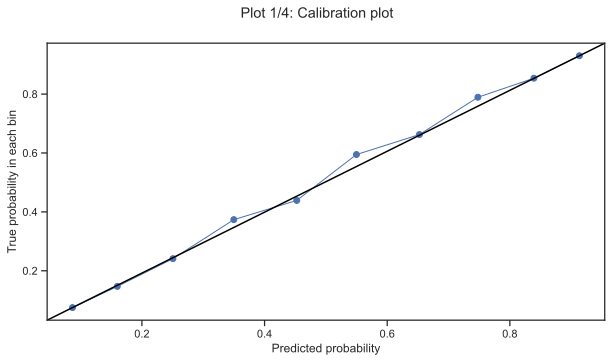

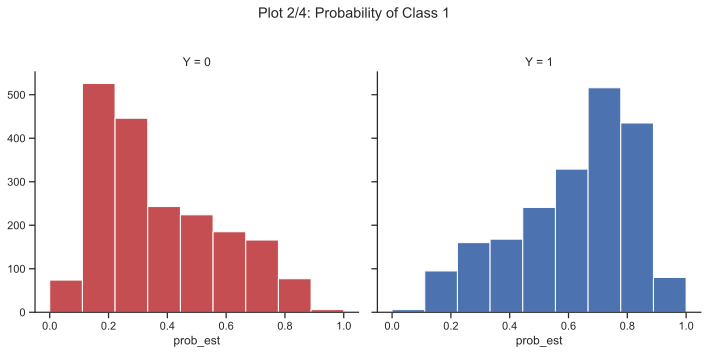

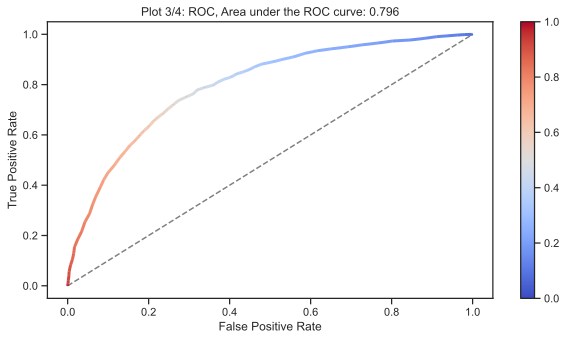

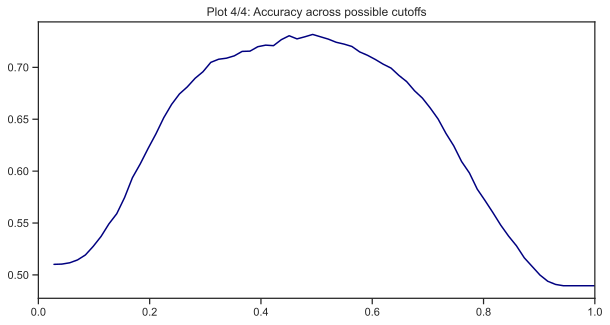

In [60]:
CT.plotClassPerformance(dfTR_eval['Y'], knn_fit.predict_proba(X_train[INPUTS_KNN]), selClass=1)

In [61]:
print(cross_val_score(knn_fit, X_train[INPUTS_KNN], y_train, cv=5, scoring='accuracy'))

[0.71984925 0.70728643 0.7245283  0.71949686 0.72955975]


#### Conclusiones Modelo KNN:

- El accuracy en el train (ajuste del modelo) ha sido 0.73
- El accuracy en el test (capacidad predictiva) ha sido 0.74
- Dado que son iguales, no hemos caído en overfitting y el test parece ser representativo del conjunto de datos.
- Se obtiene un K optimo de 166
- El accuracy si consideráramos todas las obs. 0 o 1 sería 0.5 ('No Information Rate'), como nuestra accuracy es bastante superior, tiene sentido lanzar el modelo
- Se obtiene un buen valor de precisión y recall, los cuales son ademas muy parecidos.
- En cuanto al gráfico de calibración, se observa que el modelo está  mas o menos bien claibrado pues se obtiene un gráfico prácticamente diagonal aunque desplazado hacia abajo.
- El histograma de probabilidad muestra una tendencia asimétrica, implicando que verdaderamente está dando una probabilidad tal y como era de esperar. Sin embargo, se observa que la probabilidad cuando Y=0 es muy pequeña en el extremo iquierdo (de igual manera ocurre si se observa histograma de probabilidad para Y=1) implicando que juste en esos extremos los valores predichos no son suficientemente buenos.
- El área bajo la curva ROC es de alrededor de 0.796 implicando un modelo intermedio en cuanto a buena clasificación entre TPR y FPR

#### Conclusiones con variables más significativas:
Obtenemos valores muy similares de accuracy tanto en la bondad del ajuste como en cuanto a la capacidad predictiva.
En consecuencia, no se observa ninguna mejora a partir de la consideración de variables no lineales encontradas como significativas.

### **4. Decision Tree model**

In [119]:
# Define input and output matrices
INPUTS = ['ExternalRiskEstimate', 'NetFractionRevolvingBurden',
       'AverageMInFile', 
          'MSinceOldestTradeOpen', 'PercentTradesWBalance','PercentInstallTrades', 'PerSatTrades', 'NumTotalTrades',
       'PercentTradesNeverDelq', 'MSinceMostRecentInqexcl7days'] 
OUTPUT = 'RiskPerformance' # variable de salida
X = df[INPUTS] 
y = df[OUTPUT]

# Split.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,   
                                                    random_state=0, 
                                                    stratify = y) 
## Create dataset to store model predictions
dfTR_eval = X_train.copy() # Crea 1 copia para toquetear esta y mantener train y test limpios.
dfTR_eval['Y'] = y_train # We will call Y as output variable for simplicity
dfTS_eval = X_test.copy()
dfTS_eval['Y'] = y_test # We will call Y as output variable for simplicity
#-------------------------------------------------------------------------------------------------
#---------------------------- DECISION TREE MODEL ------------------------------------------------
#-------------------------------------------------------------------------------------------------
# Define input and output matrices
INPUTS_DT = INPUTS
OUTPUT = 'RiskPerformance' # variable de salida
X = df[INPUTS_DT] 
y = df[OUTPUT]

# Split.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,   
                                                    random_state=0, 
                                                    stratify = y) 

param = {'DT__min_impurity_decrease': np.arange(0,0.05,0.005), # Minimum entropy to decrease in each split: cuanto menor sea, más le dejo crecer al árbol
        'DT__min_samples_split': np.arange(2,21,2), # Minimum number of obs in node to keep cutting
        'DT__min_samples_leaf': np.arange(2,21,2)}  # Minimum number of obs in a terminal node
pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('DT', DecisionTreeClassifier(criterion='gini',  # impuriry measure
                                                     random_state=150))]) # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
tree_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
tree_fit.fit(X_train[INPUTS_DT], y_train) # Search in grid

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('DT',
                                        DecisionTreeClassifier(random_state=150))]),
             n_jobs=-1,
             param_grid={'DT__min_impurity_decrease': array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045]),
                         'DT__min_samples_leaf': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]),
                         'DT__min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20])},
             scoring='accuracy')

In [120]:
print(tree_fit.best_estimator_)

Pipeline(steps=[('scaler', StandardScaler()),
                ('DT',
                 DecisionTreeClassifier(min_impurity_decrease=0.005,
                                        min_samples_leaf=2,
                                        random_state=150))])


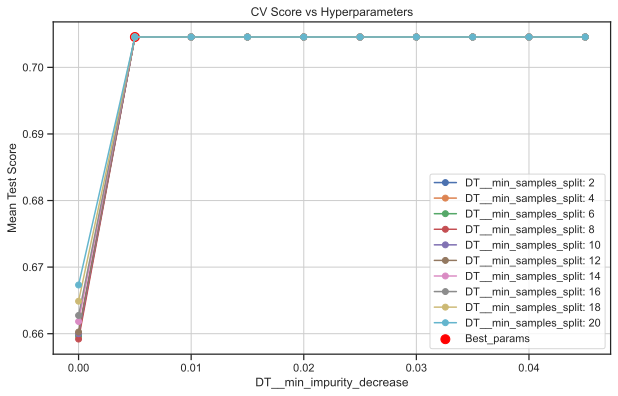

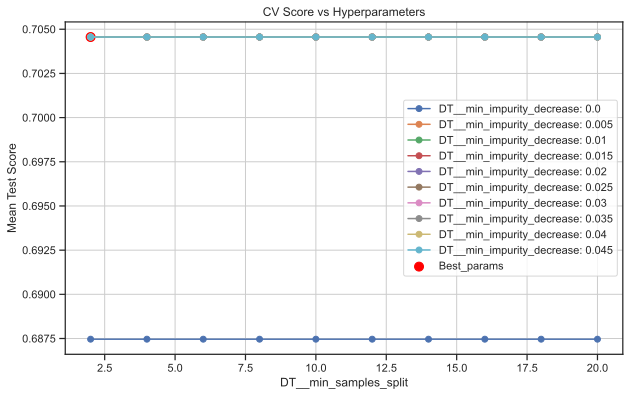

In [121]:
#MT.plotModelGridError(tree_fit, param1='DT__min_impurity_decrease', param2='DT__min_samples_split')

# Change hyperparameters 1 and 2 to see other combination of the tested CV grid
hyperparameter_1 = 'DT__min_impurity_decrease'
hyperparameter_2 = 'DT__min_samples_split'

# Obtain CV errors
cv_results = pd.DataFrame(tree_fit.cv_results_)
hyperparameters = cv_results.filter(regex='(param_.*|mean_test_score)')

# Pivot table based on the hyperparameters selected for plot afterwards
pivot_table = hyperparameters.pivot_table(values='mean_test_score', index=f'param_{hyperparameter_1}', columns=f'param_{hyperparameter_2}')
plt.figure(figsize=(10, 6))

for col in pivot_table.columns:
   plt.plot(pivot_table.index, pivot_table[col], marker='o', label=f'{hyperparameter_2}: {col}')

# Encuentra la fila y la columna correspondiente al valor máximo de la puntuación de prueba media
optimal_row, optimal_col = np.unravel_index(pivot_table.values.argmax(), pivot_table.values.shape)

# Agrega un punto rojo en el hiperparámetro óptimo
plt.scatter(pivot_table.index[optimal_row], pivot_table.values.max(), color='red', s=80, label='Best_params')

plt.title('CV Score vs Hyperparameters')
plt.xlabel(hyperparameter_1)
plt.ylabel('Mean Test Score')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 6))

#Pivot table based on the hyperparameters selected for plot afterwards
pivot_table = hyperparameters.pivot_table(values='mean_test_score', index=f'param_{hyperparameter_2}', columns=f'param_{hyperparameter_1}', aggfunc='max')

for col in pivot_table.columns:

   plt.plot(pivot_table.index, pivot_table[col], marker='o', label=f'{hyperparameter_1}: {col}')

# Encuentra la fila y la columna correspondiente al valor máximo de la puntuación de prueba media
optimal_row, optimal_col = np.unravel_index(pivot_table.values.argmax(), pivot_table.values.shape)

# Agrega un punto rojo en el hiperparámetro óptimo
plt.scatter(pivot_table.index[optimal_row], pivot_table.values.max(), color='red', s=80, label='Best_params')

plt.title('CV Score vs Hyperparameters')
plt.title('CV Score vs Hyperparameters')
plt.xlabel(hyperparameter_2)
plt.ylabel('Mean Test Score')
plt.legend()
plt.grid(True)
plt.show()

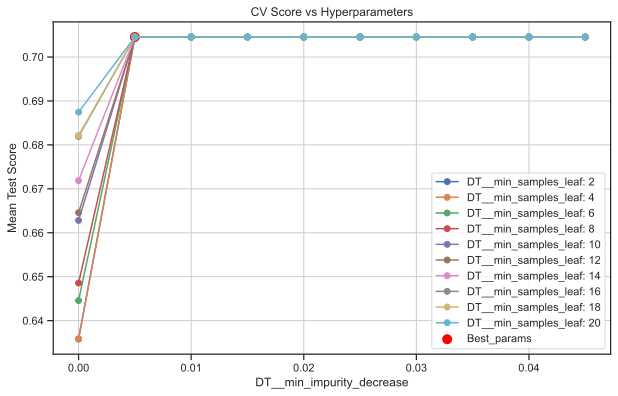

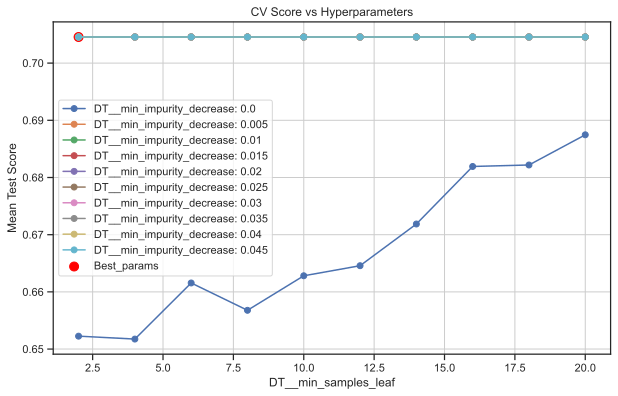

In [122]:
# Change hyperparameters 1 and 2 to see other combination of the tested CV grid
hyperparameter_1 = 'DT__min_impurity_decrease'
hyperparameter_2 = 'DT__min_samples_leaf'

# Obtain CV errors
cv_results = pd.DataFrame(tree_fit.cv_results_)
hyperparameters = cv_results.filter(regex='(param_.*|mean_test_score)')

# Pivot table based on the hyperparameters selected for plot afterwards
pivot_table = hyperparameters.pivot_table(values='mean_test_score', index=f'param_{hyperparameter_1}', columns=f'param_{hyperparameter_2}')
plt.figure(figsize=(10, 6))

for col in pivot_table.columns:
   plt.plot(pivot_table.index, pivot_table[col], marker='o', label=f'{hyperparameter_2}: {col}')

# Encuentra la fila y la columna correspondiente al valor máximo de la puntuación de prueba media
optimal_row, optimal_col = np.unravel_index(pivot_table.values.argmax(), pivot_table.values.shape)

# Agrega un punto rojo en el hiperparámetro óptimo
plt.scatter(pivot_table.index[optimal_row], pivot_table.values.max(), color='red', s=80, label='Best_params')

plt.title('CV Score vs Hyperparameters')
plt.xlabel(hyperparameter_1)
plt.ylabel('Mean Test Score')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 6))

#Pivot table based on the hyperparameters selected for plot afterwards
pivot_table = hyperparameters.pivot_table(values='mean_test_score', index=f'param_{hyperparameter_2}', columns=f'param_{hyperparameter_1}', aggfunc='max')

for col in pivot_table.columns:

   plt.plot(pivot_table.index, pivot_table[col], marker='o', label=f'{hyperparameter_1}: {col}')

# Encuentra la fila y la columna correspondiente al valor máximo de la puntuación de prueba media
optimal_row, optimal_col = np.unravel_index(pivot_table.values.argmax(), pivot_table.values.shape)

# Agrega un punto rojo en el hiperparámetro óptimo
plt.scatter(pivot_table.index[optimal_row], pivot_table.values.max(), color='red', s=80, label='Best_params')

plt.title('CV Score vs Hyperparameters')
plt.title('CV Score vs Hyperparameters')
plt.xlabel(hyperparameter_2)
plt.ylabel('Mean Test Score')
plt.legend()
plt.grid(True)
plt.show()

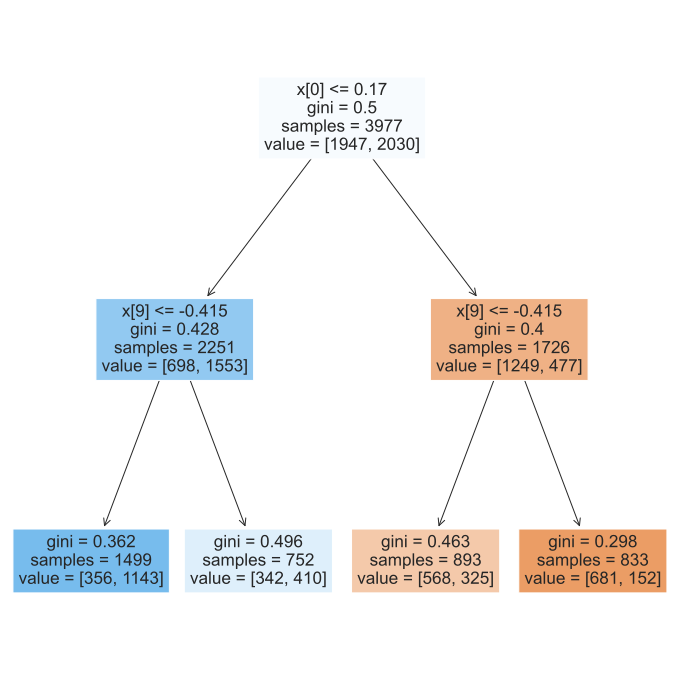

In [124]:
## Plot the decision tree model
plt.figure(figsize=(12, 12))
plot_tree(tree_fit.best_estimator_['DT'], filled=True)
plt.show()

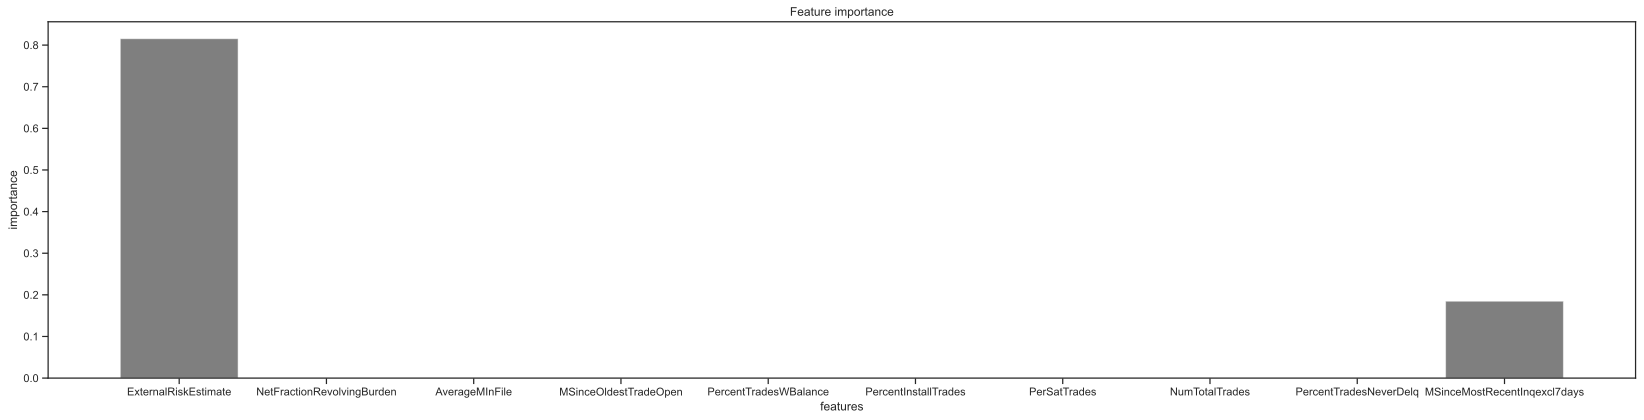

In [125]:
## Plot the variable importance of each feature
#plt.figure(figsize=(6 * 1.618, 6))
plt.figure(figsize=(23, 6))
index = np.arange(len(X_train[INPUTS_DT].columns))
bar_width = 0.35
plt.bar(index, tree_fit.best_estimator_['DT'].feature_importances_, color='black', alpha=0.5) #best_estimator es el nombre que gridsearch le da al modelo óptimo
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Feature importance')
plt.xticks(index, X_train[INPUTS_DT].columns)
plt.tight_layout()
plt.show()

In [126]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_DT_pred'] = tree_fit.predict(X_train[INPUTS_DT])
dfTR_eval['Y_DT_prob_neg'] = tree_fit.predict_proba(X_train[INPUTS_DT])[:,0]
dfTR_eval['Y_DT_prob_pos'] = tree_fit.predict_proba(X_train[INPUTS_DT])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_DT_pred'] = tree_fit.predict(X_test[INPUTS_DT])
dfTS_eval['Y_DT_prob_neg'] = tree_fit.predict_proba(X_test[INPUTS_DT])[:,0]
dfTS_eval['Y_DT_prob_pos'] = tree_fit.predict_proba(X_test[INPUTS_DT])[:,1]

#visualize evaluated data
dfTR_eval.head()

ExternalRiskEstimate  NetFractionRevolvingBurden  AverageMInFile  \
5112                    55                          65              24   
4163                    83                          27              98   
3974                    63                          83             111   
6268                    74                          42             140   
4690                    75                          61              79   

      MSinceOldestTradeOpen  PercentTradesWBalance  PercentInstallTrades  \
5112                   58.0                   89.0                    53   
4163                  204.0                   25.0                    21   
3974                  349.0                   91.0                     6   
6268                  297.0                   69.0                    21   
4690                  279.0                   60.0                    19   

      PerSatTrades  NumTotalTrades  PercentTradesNeverDelq  \
5112      0.947368            19.0                      95   
4163      1.000000            14.0                     100   
3974      0.971429            35.0                      97   
6268      0.857143            28.0                      89   
4690      1.000000            16.0                     100   

      MSinceMostRecentInqexcl7days  Y  Y_DT_pred  Y_DT_prob_neg  Y_DT_prob_pos  
5112                             0  1          1       0.237492       0.762508  
4163                             6  0          0       0.817527       0.182473  
3974                            19  1          1       0.454787       0.545213  
6268                             0  1          0       0.636058       0.363942  
4690                            22  0          0       0.817527       0.182473

In [127]:
CT.confusion_matrix(dfTR_eval['Y'], dfTR_eval['Y_DT_pred'], labels=[0,1])


Confusion Matrix and Statistics
	   Prediction
 Reference    0    1
         0 1249  698
         1  477 1553

Accuracy: 0.7
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.41
Mcnemar's Test P-Value: 0.0
Sensitivity: 0.77
Specificity: 0.64
Precision: 0.72
Recall: 0.64
Prevalence: 0.51
Detection Rate: 0.39
Detection prevalence: 0.57
Balanced accuracy: 0.7
F1 Score: 0.68
Positive label: 0


In [50]:
CT.confusion_matrix(dfTS_eval['Y'], dfTS_eval['Y_DT_pred'], labels=[0,1])

Confusion Matrix and Statistics
	   Prediction
 Reference   0   1
         0 313 174
         1 122 386

Accuracy: 0.7
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.4
Mcnemar's Test P-Value: 0.0
Sensitivity: 0.76
Specificity: 0.64
Precision: 0.72
Recall: 0.64
Prevalence: 0.51
Detection Rate: 0.39
Detection prevalence: 0.56
Balanced accuracy: 0.7
F1 Score: 0.68
Positive label: 0


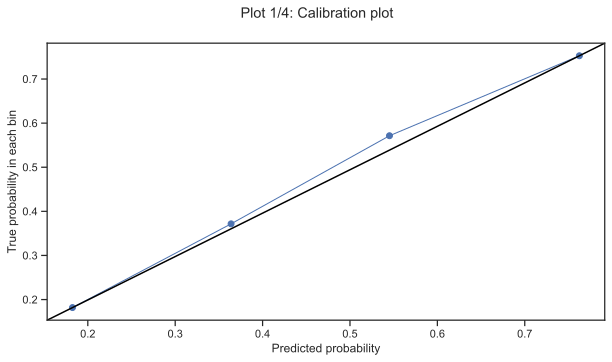

c:\Users\mcalv\anaconda3\envs\ML\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


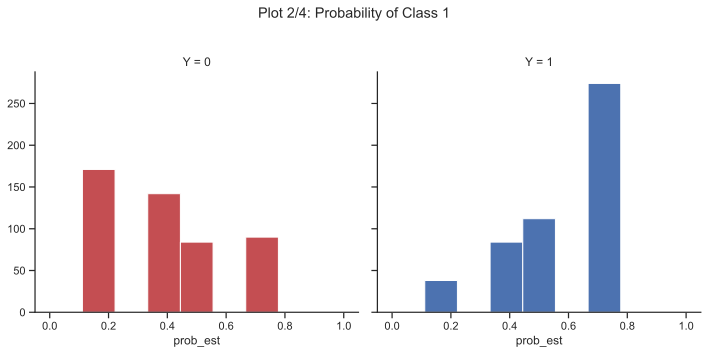

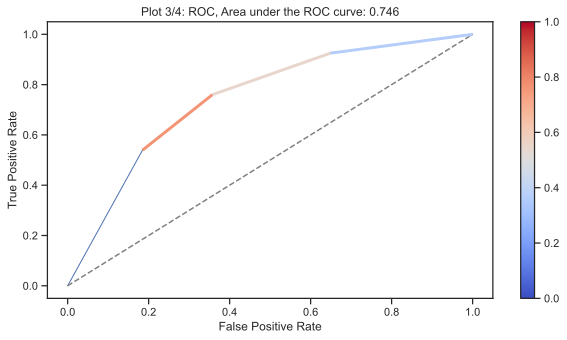

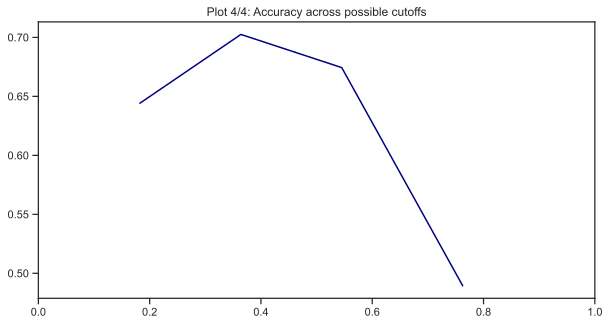

In [128]:
CT.plotClassPerformance(dfTS_eval['Y'], tree_fit.predict_proba(X_test[INPUTS_DT]), selClass=1)

In [129]:
print(cross_val_score(tree_fit, X_train[INPUTS_DT], y_train, cv=5, scoring='accuracy'))

[0.70728643 0.6959799  0.69559748 0.68553459 0.7245283 ]


#### Conclusiones Modelo DT:

- El accuracy en el train (ajuste del modelo) ha sido 0.7
- El accuracy en el test (capacidad predictiva) ha sido 0.7
- Dado que son iguales, no hemos caído en overfitting y el test parece ser representativo del conjunto de datos.
- El accuracy si consideráramos todas las obs. 0 o 1 sería 0.5 ('No Information Rate'), como nuestra accuracy es bastante superior, tiene sentido lanzar el modelo
- Sin embargo, aunque viendo únicamente el accuracy parece que el modelo lo ha hecho bien, observamos como en el gráfico de las variables importantes solo se obtienen como características las variables ExternalRiskEstimate y MSinceMostRecentInqexcl7days. Como consecuencia se observa como el arbol únicamente tiene 3 niveles. Por tanto, se puede determinar que este modelo no es el más óptimo para el problema propuesto, pues al tener en cuenta únicamente estas dos variables y no mejorar l suficiente como para seguir clasificando, se pierde información del resto de variables por el camino, no aportando una clasificación óptima.

### **4.2. Random Forest**

In [ ]:
## Inputs of the model. Change accordingly to perform variable selection
# Define input and output matrices
INPUTS = ['ExternalRiskEstimate', 'NetFractionRevolvingBurden',
       'AverageMInFile', 
          'MSinceOldestTradeOpen', 'PercentTradesWBalance','PercentInstallTrades', 'PerSatTrades', 'NumTotalTrades',
       'PercentTradesNeverDelq', 'MSinceMostRecentInqexcl7days'] 
OUTPUT = 'RiskPerformance' # variable de salida
X = df[INPUTS] 
y = df[OUTPUT]

# Split.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,   
                                                    random_state=0, 
                                                    stratify = y) 
## Create dataset to store model predictions
dfTR_eval = X_train.copy() # Crea 1 copia para toquetear esta y mantener train y test limpios.
dfTR_eval['Y'] = y_train # We will call Y as output variable for simplicity
dfTS_eval = X_test.copy()
dfTS_eval['Y'] = y_test # We will call Y as output variable for simplicity
INPUTS_RF = INPUTS

param = {'RF__n_estimators': range(10, 200, 10),
        'RF__min_samples_split': np.arange(2,21,2), # Minimum number of obs in node to keep cutting
        'RF__min_samples_leaf': np.arange(2,21,2)} #Number of trees to grow
pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('RF', RandomForestClassifier(criterion='gini', # impuriry measure
                                                    max_features=len(X_train.columns),  # number of variables randomly sampled as candidates at each split.
                                                    random_state=150))]) # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
rf_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
rf_fit.fit(X_train[INPUTS_RF], y_train) # Search in grid

In [ ]:
print(rf_fit.best_estimator_)

In [ ]:
cv_results

In [ ]:
# Change hyperparameters 1 and 2 to see other combination of the tested CV grid
hyperparameter_1 = 'RF__n_estimators'
hyperparameter_2 = 'RF__min_samples_split'

# Obtain CV errors
cv_results = pd.DataFrame(rf_fit.cv_results_)
hyperparameters = cv_results.filter(regex='(param_.*|mean_test_score)')

# Pivot table based on the hyperparameters selected for plot afterwards
pivot_table = hyperparameters.pivot_table(values='mean_test_score', index=f'param_{hyperparameter_1}', columns=f'param_{hyperparameter_2}')
plt.figure(figsize=(10, 6))

for col in pivot_table.columns:
   plt.plot(pivot_table.index, pivot_table[col], marker='o', label=f'{hyperparameter_2}: {col}')

# Encuentra la fila y la columna correspondiente al valor máximo de la puntuación de prueba media
optimal_row, optimal_col = np.unravel_index(pivot_table.values.argmax(), pivot_table.values.shape)

# Agrega un punto rojo en el hiperparámetro óptimo
plt.scatter(pivot_table.index[optimal_row], pivot_table.values.max(), color='red', s=80, label='Best_params')

plt.title('CV Score vs Hyperparameters')
plt.xlabel(hyperparameter_1)
plt.ylabel('Mean Test Score')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 6))

#Pivot table based on the hyperparameters selected for plot afterwards
pivot_table = hyperparameters.pivot_table(values='mean_test_score', index=f'param_{hyperparameter_2}', columns=f'param_{hyperparameter_1}', aggfunc='max')

for col in pivot_table.columns:

   plt.plot(pivot_table.index, pivot_table[col], marker='o', label=f'{hyperparameter_1}: {col}')

# Encuentra la fila y la columna correspondiente al valor máximo de la puntuación de prueba media
optimal_row, optimal_col = np.unravel_index(pivot_table.values.argmax(), pivot_table.values.shape)

# Agrega un punto rojo en el hiperparámetro óptimo
plt.scatter(pivot_table.index[optimal_row], pivot_table.values.max(), color='red', s=80, label='Best_params')

plt.title('CV Score vs Hyperparameters')
plt.title('CV Score vs Hyperparameters')
plt.xlabel(hyperparameter_2)
plt.ylabel('Mean Test Score')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Change hyperparameters 1 and 2 to see other combination of the tested CV grid
hyperparameter_1 = 'RF__n_estimators'
hyperparameter_2 = 'RF__min_samples_leaf'

# Obtain CV errors
cv_results = pd.DataFrame(rf_fit.cv_results_)
hyperparameters = cv_results.filter(regex='(param_.*|mean_test_score)')

# Pivot table based on the hyperparameters selected for plot afterwards
pivot_table = hyperparameters.pivot_table(values='mean_test_score', index=f'param_{hyperparameter_1}', columns=f'param_{hyperparameter_2}')
plt.figure(figsize=(10, 6))

for col in pivot_table.columns:
   plt.plot(pivot_table.index, pivot_table[col], marker='o', label=f'{hyperparameter_2}: {col}')

# Encuentra la fila y la columna correspondiente al valor máximo de la puntuación de prueba media
optimal_row, optimal_col = np.unravel_index(pivot_table.values.argmax(), pivot_table.values.shape)

# Agrega un punto rojo en el hiperparámetro óptimo
plt.scatter(pivot_table.index[optimal_row], pivot_table.values.max(), color='red', s=80, label='Best_params')

plt.title('CV Score vs Hyperparameters')
plt.xlabel(hyperparameter_1)
plt.ylabel('Mean Test Score')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 6))

#Pivot table based on the hyperparameters selected for plot afterwards
pivot_table = hyperparameters.pivot_table(values='mean_test_score', index=f'param_{hyperparameter_2}', columns=f'param_{hyperparameter_1}', aggfunc='max')

for col in pivot_table.columns:

   plt.plot(pivot_table.index, pivot_table[col], marker='o', label=f'{hyperparameter_1}: {col}')

# Encuentra la fila y la columna correspondiente al valor máximo de la puntuación de prueba media
optimal_row, optimal_col = np.unravel_index(pivot_table.values.argmax(), pivot_table.values.shape)

# Agrega un punto rojo en el hiperparámetro óptimo
plt.scatter(pivot_table.index[optimal_row], pivot_table.values.max(), color='red', s=80, label='Best_params')

plt.title('CV Score vs Hyperparameters')
plt.title('CV Score vs Hyperparameters')
plt.xlabel(hyperparameter_2)
plt.ylabel('Mean Test Score')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
## Plot the variable importance of each feature
#plt.figure(figsize=(6 * 1.618, 6))
plt.figure(figsize=(23, 6))
index = np.arange(len(X_train[INPUTS_RF].columns))
bar_width = 0.35
plt.bar(index, rf_fit.best_estimator_['RF'].feature_importances_, color='black', alpha=0.5)
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Feature importance')
plt.xticks(index, X_train.columns)
plt.tight_layout()
plt.show()

In [ ]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_RF_pred'] = rf_fit.predict(X_train[INPUTS_RF])
dfTR_eval['Y_RF_prob_neg'] = rf_fit.predict_proba(X_train[INPUTS_RF])[:,0]
dfTR_eval['Y_RF_prob_pos'] = rf_fit.predict_proba(X_train[INPUTS_RF])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_RF_pred'] = rf_fit.predict(X_test[INPUTS_RF])
dfTS_eval['Y_RF_prob_neg'] = rf_fit.predict_proba(X_test[INPUTS_RF])[:,0]
dfTS_eval['Y_RF_prob_pos'] = rf_fit.predict_proba(X_test[INPUTS_RF])[:,1]

dfTR_eval.head()

In [ ]:
CT.confusion_matrix(dfTR_eval['Y'], dfTR_eval['Y_RF_pred'], labels=[0,1])

In [ ]:
CT.confusion_matrix(dfTS_eval['Y'], dfTS_eval['Y_RF_pred'], labels=[0,1])

In [ ]:
CT.plotClassPerformance(dfTS_eval['Y'], rf_fit.predict_proba(X_test[INPUTS_RF]), selClass=1)

In [ ]:
print(cross_val_score(rf_fit, X_train[INPUTS_RF], y_train, cv=5, scoring='accuracy'))

### **5. SVM model**

In [55]:
#-------------------------------------------------------------------------------------------------
#------------------------------- LINEAR SVM MODEL ------------------------------------------------
#-------------------------------------------------------------------------------------------------
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_LSVC = INPUTS

param = {'SVC__C': [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]} # Cost term
pipe = Pipeline(steps=[ ('scaler', StandardScaler()), 
                        ('SVC',  SVC(kernel='linear', # lineal kernel
                                    probability=True, # let the model predict probabilities
                                    random_state=150))]) # For replication


# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 5
Linear_SVC_gcv = GridSearchCV(estimator=pipe, # Structure of the model to use
                        param_grid=param, # Defined grid to search in
                        n_jobs=-1, # Number of cores to use (parallelize)
                        scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                        cv=nFolds) # Number of Folds 
Linear_SVC_gcv.fit(X_train[INPUTS_LSVC], y_train) # Search in grid

# We use Calibrated CV to transform predictions of the model to probabilities due to a known bug in scikit SVC
#pq este  modelo, a diferencia de los anteriores, no nos permite sacar probabilidades
Linear_SVC_fit = CalibratedClassifierCV(
                        base_estimator=Linear_SVC_gcv, # Structure of the model to use
                        n_jobs=-1, # Number of cores to use (parallelize)
                        method='isotonic', # The method to use for calibration
                        cv=nFolds) # Number of Folds 
Linear_SVC_fit.fit(X_train[INPUTS_LSVC], y_train) # Search in grid


KeyboardInterrupt: 

In [ ]:
MT.plotModelGridError(Linear_SVC_fit.base_estimator, xscale="log")

In [ ]:
# Obtain Cross-Validation score
print("CV accuracy is")
cross_val_score(Linear_SVC_fit, X_train[INPUTS_LSVC], y_train, cv=10, scoring='accuracy').mean()

In [ ]:
## Plot the variable coefficient of each feature
plt.figure(figsize=(6 * 1.618, 6))
index = np.arange(len(X_train[INPUTS_LSVC].columns))
bar_width = 0.35
plt.bar(index, Linear_SVC_fit.base_estimator.best_estimator_['SVC'].coef_[0,:], color='black', alpha=0.5)
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.title('Coefficients of features')
plt.xticks(index, X_train[INPUTS_LSVC].columns)
plt.tight_layout()
plt.show()

In [ ]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_LSVC_pred'] = Linear_SVC_fit.predict(X_train[INPUTS_LSVC])
dfTR_eval['Y_LSVC_prob_neg'] = Linear_SVC_fit.predict_proba(X_train[INPUTS_LSVC])[:,0]
dfTR_eval['Y_LSVC_prob_pos'] = Linear_SVC_fit.predict_proba(X_train[INPUTS_LSVC])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_LSVC_pred'] = Linear_SVC_fit.predict(X_test[INPUTS_LSVC])
dfTS_eval['Y_LSVC_prob_neg'] = Linear_SVC_fit.predict_proba(X_test[INPUTS_LSVC])[:,0]
dfTS_eval['Y_LSVC_prob_pos'] = Linear_SVC_fit.predict_proba(X_test[INPUTS_LSVC])[:,1]

#visualize evaluated data
dfTR_eval.head()

In [ ]:
CT.confusion_matrix(dfTR_eval['Y'], dfTR_eval['Y_LSVC_pred'], labels=[0,1])

In [ ]:
CT.confusion_matrix(dfTS_eval['Y'], dfTS_eval['Y_LSVC_pred'], labels=[0,1])

In [ ]:
CT.plotClassPerformance(dfTS_eval['Y'], Linear_SVC_fit.predict_proba(X_test[INPUTS_LSVC]), selClass=1)

**Se podría hacer también el SVM radial.**

### **6. MLP model**

In [ ]:
#-------------------------------------------------------------------------------------------------
#------------------------------- MLP Class MODEL -------------------------------------------------
#-------------------------------------------------------------------------------------------------
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_MLP = INPUTS

# posibles valores para  los hiperparámetros:
# realmente el hiperparámetro se llama 'alpha', pero tengo que darle 'MLP__nombre' pq el nombre abajo es 'MLP'
param = {'MLP__alpha': [1e-9,1e-7,1e-5,0.001,0.01], # L2 regularization term 
         'MLP__hidden_layer_sizes':[(5,),(10,),(15,),(20,),(25,)]} # Number of neurons in each hidden layer, enters as tuples

# si no quiero tunearlo, sino pasarles directamente un valor:
#param = {'MLP__alpha': [0], # L2 regularization term 
#         'MLP__hidden_layer_sizes':[(20,)]} # Number of neurons in each hidden layer, enters as tuples

pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('MLP', MLPClassifier(solver='lbfgs', # Update function -> optimizador (usa info d la 2ª derivada) -> para datasets con menor de 10000 muestras y 20 variables es mejor q el adam -> en los otros mejor el adam
                                             activation='logistic', # Logistic sigmoid activation function
                                             max_iter=450, # Maximum number of iterations
                                             tol=1e-4, # Tolerance for the optimization (ratio de convergencia, si mejoras menos d ese error, párate)
                                             random_state=150,   #semilla aleatoria (pq cada vez inicializará unos pesos diferentes)
                                             verbose = True))]) # true -> te da info a la vez que se va entrenando

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
MLP_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
MLP_fit.fit(X_train[INPUTS_MLP], y_train) # Search in grid

In [ ]:
MT.plotModelGridError(MLP_fit, xscale2="log") 

In [ ]:
mlp = MLP_fit.best_estimator_['MLP']
wts = mlp.coefs_
bias = mlp.intercepts_
actfunc = ['identity',MLP_fit.best_estimator_['MLP'].get_params()['activation'],mlp.out_activation_]
X = MLP_fit.best_estimator_['scaler'].transform(X_train[INPUTS_MLP])
X = pd.DataFrame(X, columns=X_train[INPUTS_MLP].columns)
y = pd.DataFrame(y_train, columns=X_train[INPUTS_MLP].columns)
sens_end_layer = 'last'
sens_end_input = False
sens_origin_layer = 0
sens_origin_input = True

In [ ]:
sensmlp = ns.jacobian_mlp(wts, bias, actfunc, X[INPUTS_MLP], y, use_torch=False)

In [ ]:
sensmlp.summary()

In [ ]:
sensmlp.info()

In [ ]:
sensmlp.plot()

In [ ]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_MLP_pred'] = MLP_fit.predict(X_train[INPUTS_MLP])
dfTR_eval['Y_MLP_prob_neg'] = MLP_fit.predict_proba(X_train[INPUTS_MLP])[:,0]
dfTR_eval['Y_MLP_prob_pos'] = MLP_fit.predict_proba(X_train[INPUTS_MLP])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_MLP_pred'] = MLP_fit.predict(X_test[INPUTS_MLP])
dfTS_eval['Y_MLP_prob_neg'] = MLP_fit.predict_proba(X_test[INPUTS_MLP])[:,0]
dfTS_eval['Y_MLP_prob_pos'] = MLP_fit.predict_proba(X_test[INPUTS_MLP])[:,1]

#visualize evaluated data
dfTR_eval.head()

In [ ]:
CT.confusion_matrix(dfTR_eval['Y'], dfTR_eval['Y_MLP_pred'], labels=[0,1])

In [ ]:
CT.confusion_matrix(dfTS_eval['Y'], dfTS_eval['Y_MLP_pred'], labels=[0,1])

In [ ]:
CT.plotClassPerformance(dfTS_eval['Y'], MLP_fit.predict_proba(X_test[INPUTS_MLP]), selClass=1)

### **7. Comparative analysis of models**

**(En todos falta añadir la parte del MLP)**

In [ ]:
## Compare models
metric = 'Accuracy'
score = {'LogReg': cross_val_score(LogReg_fit, X_train[INPUTS_LR], y_train, cv=10, scoring='accuracy'), 
            #'LogReg_sq': cross_val_score(LogReg_fit_sq, X_train[INPUTS_LR2], y_train, cv=10, scoring='accuracy'),  
        'knn': cross_val_score(knn_fit, X_train[INPUTS_KNN], y_train, cv=5, scoring='accuracy'),
        'Decision Tree': cross_val_score(tree_fit, X_train[INPUTS_DT], y_train, cv=5, scoring='accuracy'), 
             #'Random Forest': cross_val_score(rf_fit, X_train[INPUTS_RF], y_train, cv=10, scoring='accuracy'),
        'Linear SVC': cross_val_score(Linear_SVC_fit, X_train[INPUTS_LSVC], y_train, cv=10, scoring='accuracy')#, 
             #'Radial SVC': cross_val_score(SVC_fit, X_train[INPUTS_RSVC], y_train, cv=10, scoring='accuracy')
         #'Multi-Layer Perc.': cross_val_score( , , y_train, cv=10, scoring='accuracy')
        }
MT.dotplot(score, metric)

In [ ]:
#CT.calibration_plot(y_test, dfTS_eval[['Y_LR_prob_pos','Y_LR_sq_prob_pos','Y_knn_prob_pos']])
#CT.calibration_plot(y_test, dfTS_eval[['Y_DT_prob_pos','Y_RF_prob_pos']])
#CT.calibration_plot(y_test, dfTS_eval[['Y_LSVC_prob_pos','Y_SVC_prob_pos']])
CT.calibration_plot(y_test, dfTS_eval[['Y_LR_prob_pos','Y_knn_prob_pos','Y_DT_prob_pos','Y_LSVC_prob_pos' ]])


In [ ]:
#CT.roc_curve(y_test,dfTS_eval[['Y_LR_prob_pos','Y_LR_sq_prob_pos','Y_knn_prob_pos']], 'YES')
#CT.roc_curve(y_test,dfTS_eval[['Y_DT_prob_pos','Y_RF_prob_pos']], 'YES')
#CT.roc_curve(y_test,dfTS_eval[['Y_LSVC_prob_pos','Y_SVC_prob_pos']], 'YES')
CT.roc_curve(y_test,dfTS_eval[['Y_LR_prob_pos','Y_knn_prob_pos','Y_DT_prob_pos','Y_LSVC_prob_pos']], 1)

### XGBoost:


In [ ]:
!pip uninstall xgboost (Y)
#!pip install xgboost
import xgboost as xgb
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_wine
from sklearn.model_selection import KFold

In [31]:
params = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01,0.05,0.1],
    'booster': ['gbtree', 'gblinear'],
    'max_depth': [2,4,6,8]
}

gs2 = GridSearchCV(XGBClassifier(n_jobs=-1), params, n_jobs=-1, cv=KFold(n_splits=5), scoring='accuracy')
gs2.fit(X_train, y_train)

print('Best score:', gs2.best_score_)
print('Best score:', gs2.best_params_)

Best score: 0.7261777440662432
Best score: {'booster': 'gbtree', 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500}


In [36]:
best_xgb_model = gs2.best_estimator_

array([0.45458117, 0.08288516, 0.05559729, 0.0448183 , 0.03866337,
       0.04534172, 0.03449671, 0.04436021, 0.06622475, 0.13303135],
      dtype=float32)

In [ ]:
prediction=gs2.predict(X_test)
 
#Measuring accuracy on Testing Data
from sklearn import metrics
print(metrics.classification_report(y_test, prediction))
print(metrics.confusion_matrix(y_test, prediction))
 

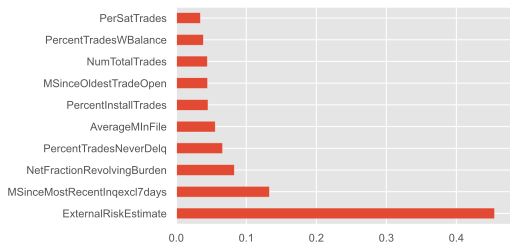

In [39]:
#Plotting the feature importance for Top 10 most important columns
%matplotlib inline
feature_importances = pd.Series(best_xgb_model.feature_importances_, index=INPUTS)
feature_importances.nlargest(10).plot(kind='barh')
plt.savefig("FeatureImportances.jpg", bbox_inches='tight')

Finally, as an additional prediction method, we have decided to implement XGBoost.

XGBoost is a supervised machine learning method for classification and regression, although in this case it will only be used for classification.

XGBoost is short for "extreme gradient boosting". This method is based on decision trees and is an improvement over other methods, such as random forest and gradient boosting. We will use it because among its advantages are that it works well with large and complex datasets when using various optimization methods.

As we have done in previous methods, we will use all the variables selected in preprocessing as inputs.

Regarding the hyperparameters, we find:
- max_depth: The maximum depth of a tree, it is used to control over-fitting as higher depth will allow model to learn very specific relations to a particular sample.

- learning_rate: It is the step size shrinkage used in update to prevent overfitting. After each boosting step, we can directly get the weights of new features, and this shrinks the feature weights to make the boosting process more conservative. It makes the model more robust by shrinking the weights on each step. (It ranges between 0 and 1).

- n_estimators: represents the number of trees that will be adjusted sequentially during the boosting process. Each tree is fitted in a way that corrects the errors of the previous model. The value of n_estimators determines the number of iterations or tuning stages that will be performed. A larger value of n_estimators will generally lead to a more complex and powerful model, but can also increase the risk of overfitting if set too high.

Once we have trained the model, it is obtained that the optimal values ​​for the hyperparameters in this model are:
- 'max_depth': 4,
- 'learning_rate': 0.05,
- 'n_estimators': 100

With these values ​​for the hyperparameters, we achieve an average value for the accuracy in the cross-validation equal to 0.723.

While in terms of the goodness of fit and the predictive capacity of the model, accuracy of the train and accuracy of the test set respectively, an accuracy = 0.78 is obtained in the train and accuracy = 0.73 in the test.

That is, from the data that make up the train, we are able to predict them more correctly than predicting new values. With this case, we manage to correctly classify 73% of the new observations.

Consequently, this model has been a little bit overtrained, it faces overfitting.

Regarding the most significant variables in the model, as the following graph shows, it is mainly "ExternalRiskEstimate" and "MSinceMostRecentInqexcl7days" that have the greatest relevance in the model.

In [42]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_DT_pred'] = best_xgb_model.predict(X_train[INPUTS])
dfTR_eval['Y_DT_prob_neg'] = best_xgb_model.predict_proba(X_train[INPUTS])[:,0]
dfTR_eval['Y_DT_prob_pos'] = best_xgb_model.predict_proba(X_train[INPUTS])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_DT_pred'] = best_xgb_model.predict(X_test[INPUTS])
dfTS_eval['Y_DT_prob_neg'] = best_xgb_model.predict_proba(X_test[INPUTS])[:,0]
dfTS_eval['Y_DT_prob_pos'] = best_xgb_model.predict_proba(X_test[INPUTS])[:,1]

#visualize evaluated data
dfTR_eval.head()

ExternalRiskEstimate  NetFractionRevolvingBurden  AverageMInFile  \
5112                    55                          65              24   
4163                    83                          27              98   
3974                    63                          83             111   
6268                    74                          42             140   
4690                    75                          61              79   

      MSinceOldestTradeOpen  PercentTradesWBalance  PercentInstallTrades  \
5112                   58.0                   89.0                    53   
4163                  204.0                   25.0                    21   
3974                  349.0                   91.0                     6   
6268                  297.0                   69.0                    21   
4690                  279.0                   60.0                    19   

      PerSatTrades  NumTotalTrades  PercentTradesNeverDelq  \
5112      0.947368            19.0                      95   
4163      1.000000            14.0                     100   
3974      0.971429            35.0                      97   
6268      0.857143            28.0                      89   
4690      1.000000            16.0                     100   

      MSinceMostRecentInqexcl7days  Y  Y_DT_pred  Y_DT_prob_neg  Y_DT_prob_pos  
5112                             0  1          1       0.072973       0.927027  
4163                             6  0          0       0.846967       0.153033  
3974                            19  1          1       0.221527       0.778473  
6268                             0  1          1       0.484434       0.515566  
4690                            22  0          0       0.806812       0.193188

In [32]:
CT.confusion_matrix(dfTR_eval['Y'], dfTR_eval['Y_DT_pred'], labels=[0,1])

Confusion Matrix and Statistics
	   Prediction
 Reference    0    1
         0 1473  474
         1  397 1633

Accuracy: 0.78
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.56
Mcnemar's Test P-Value: 0.01
Sensitivity: 0.8
Specificity: 0.76
Precision: 0.79
Recall: 0.76
Prevalence: 0.51
Detection Rate: 0.41
Detection prevalence: 0.53
Balanced accuracy: 0.78
F1 Score: 0.77
Positive label: 0


In [33]:
CT.confusion_matrix(dfTS_eval['Y'], dfTS_eval['Y_DT_pred'], labels=[0,1])

Confusion Matrix and Statistics
	   Prediction
 Reference   0   1
         0 346 141
         1 123 385

Accuracy: 0.73
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.47
Mcnemar's Test P-Value: 0.3
Sensitivity: 0.76
Specificity: 0.71
Precision: 0.74
Recall: 0.71
Prevalence: 0.51
Detection Rate: 0.39
Detection prevalence: 0.53
Balanced accuracy: 0.73
F1 Score: 0.72
Positive label: 0


In [ ]:
#CT.plotClassPerformance(dfTS_eval['Y'], XGB.predict_proba(X_test[INPUTS]), selClass=1)

In [59]:
#dfTR_eval.to_csv('./dfTR_eval.csv', index= False)
#dfTS_eval.to_csv('./dfTS_eval.csv', index= False)

In [31]:
#dfTR_eval = pd.read_csv('./dfTR_eval.csv')
#dfTS_eval = pd.read_csv('./dfTS_eval.csv')

## **7. Comparative analysis of models**

In [ ]:
## Compare models
metric = 'Accuracy'
score = {'LogReg': cross_val_score(LogReg_fit, X_train[INPUTS_LR], y_train, cv=10, scoring='accuracy'), 
            #'LogReg_sq': cross_val_score(LogReg_fit_sq, X_train[INPUTS_LR2], y_train, cv=10, scoring='accuracy'),  
        'knn': cross_val_score(knn_fit, X_train[INPUTS_KNN], y_train, cv=5, scoring='accuracy'),
        'Decision Tree': cross_val_score(tree_fit, X_train[INPUTS_DT], y_train, cv=5, scoring='accuracy'), 
             #'Random Forest': cross_val_score(rf_fit, X_train[INPUTS_RF], y_train, cv=10, scoring='accuracy'),
        'Linear SVC': cross_val_score(Linear_SVC_fit, X_train[INPUTS_LSVC], y_train, cv=10, scoring='accuracy')#, 
             #'Radial SVC': cross_val_score(SVC_fit, X_train[INPUTS_RSVC], y_train, cv=10, scoring='accuracy')
         #'Multi-Layer Perc.': cross_val_score( , , y_train, cv=10, scoring='accuracy')
        }
MT.dotplot(score, metric)

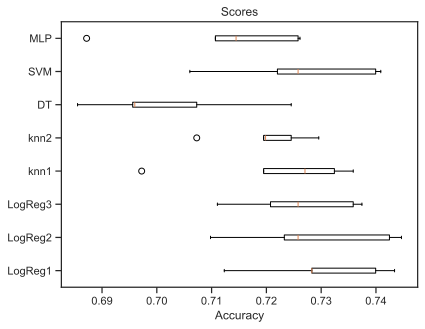

In [68]:
# falta del random forest, svm radial y xgboost
logreg1 = [0.73994975, 0.71231156, 0.72830189, 0.72830189, 0.74339623]
logreg2 = [0.74246231, 0.70979899, 0.72327044 ,0.72578616, 0.74465409]
logreg3 = [0.73743719 ,0.71105528, 0.72075472, 0.72578616 ,0.73584906]

knn1 = [0.73241206, 0.69723618, 0.72704403, 0.71949686, 0.73584906]
knn2 = [0.71984925, 0.70728643, 0.7245283,  0.71949686, 0.72955975]

dt = [0.70728643, 0.6959799,  0.69559748, 0.68553459, 0.7245283]

svm = [0.73994975, 0.70603015, 0.72201258, 0.72578616, 0.7408805]

mlp = [0.72613065, 0.68718593, 0.72578616, 0.71446541, 0.71069182]

metric = 'Accuracy'
score = {'LogReg1': logreg1, 'LogReg2': logreg2, 'LogReg3': logreg3,
         'knn1': knn1, 'knn2': knn2, 'DT': dt, 'SVM': svm, 'MLP': mlp}   

MT.dotplot(score, metric)

In [ ]:
CT.calibration_plot(y_test, dfTS_eval[['Y_LR_prob_pos','Y_LR_sq_prob_pos','Y_knn_prob_pos']])

In [ ]:
CT.roc_curve(y_test,dfTS_eval[['Y_LR_prob_pos','Y_LR_sq_prob_pos','Y_knn_prob_pos']], 'YES')